### Instagis - Data Science Technical test 
Version 1.1.4

# Assignment  2: Classification problem

Using previously classified comments, generate **at least** two types of classifers to detect positive and negative comments. 

Note that you can generate new features or classes.

## My approach to the problem, the tasks performed and the main conclusions by iteration


### Set the benchmarks

* Minimum: Above 69% of Accuracy, f1-score of 37% and 80% for negatives and positive sentiment, respectively.

* Benchmark: Above 80% of Accuracy (convention, because is the same understanding as humans) and 80% of roc-auc score

### Iteration three: Re-label the data with 3 sentiments using the Vader package and using the previous approuch

* Since we realize in the past iteration that many of the "errors" of our classifier wasn't really errors but was misslabeled data, we decide to relabel the data using the MIT package call VaderSentiment package, which provides a good approuch to sentiment analysis, takes the semantic of the sentences and was develop for social media. The plan is re-label the data with three classes (positive, neutral and negative) which is more realistic and build a classifier which is capable to capture the patterns in the data and predict which of this threee sentiment has more emphasis in each sentence.

* **Main Conclusions: **

    * The solution provides results above the minimum in the training of the first iteration and with the same parameters than the other solutions, so we decide to drop this idea and try something different in the next iteration

## Disclaimer

* After i complete the second iteration with the model and get 72% of Accuracy and 0.71 roc-auc score, i post this in
  the Big Data and Data Science comunnity asking for ideas to make an improvement in the model. I did recieve help
  with ideas but all the implementation of them i made it myself, so it's the same as read a blog or any post on the
  internet.If you want to check the ideas that i recieved, you can go to this link:

*<https://www.facebook.com/groups/big.data.science.chile/permalink/2009665029359437/>*

* In any case, if you consider that it was not appropriate to receive help with ideas to implement, I separated the solution into version one and the others, so that you can evaluate only the first version, if you deem it convenient.


* Also, i use the vaderPackage to set up a minimium threshold to the accuracy of the model after read some ideas in the post. Before that, my benchmark was only get to the accuracy of 80%, which is the standar benchmark un sentiment analysis to say that is a very good model (convention, because is the same understanding as humans)

** Another references used **

*<https://machinelearningmastery.com/vector-norms-machine-learning/>*

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from itertools import chain
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import spacy
import string
import emoji
from time import time
from collections import Counter
# Library's to plot
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import plotly.plotly as py
from plotly import graph_objs as go
from plotly.graph_objs import Figure,Layout,Scatter,Bar
from plotly.graph_objs import *
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from sklearn.preprocessing import binarize,MinMaxScaler,RobustScaler,normalize,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_selection import  mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import log_loss,roc_curve,classification_report,confusion_matrix,make_scorer
# Init the spacy object call parser
parser = spacy.load("en")

In [2]:
def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=20,
        n_estimators=500,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =20)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,learning_rate=0.01,
        n_estimators=500,min_samples_split = 20,warm_start=True,presort=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Linear SVC
    lsvc = LinearSVC(C=0.01, penalty="l1", random_state=0,dual=False,
                     loss='squared_hinge').fit(X, y)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Linear SVC
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
    features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
    features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
    selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                               sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
    
    return selected_features

In [ ]:
def restart_classifiers():
    classifier_LR = LogisticRegression(random_state=0,
                                   warm_start=True,C=0.01,max_iter=300)
    classifier_RF = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=True,n_jobs=-1, min_samples_leaf =50)
    classifier_GB = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,learning_rate=0.01,n_estimators=300,
        min_samples_split = 40,warm_start=True,presort=False)
    classifier_BNB=BernoulliNB(class_prior=[0.259,0.741])
    classifier_MNB = MultinomialNB(class_prior=[0.259,0.741])
    classifier_linearSVC=LinearSVC(loss='hinge', penalty='l2',C=0.01)
    classifier_rbfSVC=SVC(kernel='rbf',C=0.01,probability=True,max_iter=300)
    classifier_PAC = PassiveAggressiveClassifier(max_iter=100,C=0.1,random_state=0,warm_start=True)
    algorithms=[classifier_LR,classifier_BNB,classifier_MNB,classifier_linearSVC,
                classifier_RF,classifier_GB,classifier_PAC]
    classifier_LR_wc = LogisticRegression(random_state=0,class_weight='balanced',
                                   warm_start=False,C=0.01,max_iter=300)
    classifier_RF_wc = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=False,n_jobs=-1, min_samples_leaf =50,class_weight='balanced')
    classifier_PAC_wc = PassiveAggressiveClassifier(max_iter=100,C=0.1,random_state=0,class_weight='balanced')
    algorithms_wc=[classifier_LR_wc,classifier_BNB,classifier_MNB,classifier_linearSVC,
                   classifier_RF_wc,classifier_GB,classifier_PAC_wc]
    
    return [algorithms,algorithms_wc]

In [4]:
def restart_multinomial_classifiers():
    classifier_LR =LogisticRegression(multi_class='multinomial', solver='newton-cg',random_state=0,
                                      warm_start=True,C=0.01,max_iter=300)
    classifier_RF = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=True,n_jobs=-1, min_samples_leaf =50)
    classifier_BNB=BernoulliNB()
    classifier_linearSVC=LinearSVC(penalty='l2',C=0.01,multi_class="crammer_singer")
    algorithms=[classifier_LR,classifier_BNB,classifier_RF,classifier_linearSVC]
    
    classifier_LR_wc = LogisticRegression(random_state=0,class_weight='balanced',multi_class='multinomial', 
                                          solver='newton-cg',warm_start=False,C=0.01,max_iter=300)
    classifier_RF_wc = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=False,n_jobs=-1, min_samples_leaf =50,class_weight='balanced')
    algorithms_wc=[classifier_LR_wc,classifier_BNB,classifier_linearSVC,classifier_RF_wc]

    return [algorithms,algorithms_wc]

In [5]:
def train_classifier(X_train, y_train, X_test, models,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train, 
                                    cv = 10,return_train_score=False,)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test average-precision'] = cv_results['test_average-precision'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        compare_table.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
        compare_table.loc[row_index, 'Test Recall'] = cv_results['test_recall'].mean() 
        compare_table.loc[row_index, 'Test F1'] = cv_results['test_F1'].mean()
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [6]:
def test_classifier(X_train, y_train, X_test, y_test, classifier,probs=False):
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting values time {0}s".format(time() - now))
    if(probs):
        now = time()
        probs_prediction= model.predict_proba(X_test)
        print("Predicting probs time {0}s".format(time() - now))
        roc_auc   = roc_auc_score(y_test, probs_prediction[:,1])
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall    = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy  = accuracy_score(y_test, predictions)
    f1score   = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    cr        = classification_report(y_test, predictions)
    cm        = pd.crosstab(y_test, predictions, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
    results   = {classifier_name: 
                 {
                     'F1':f1score,
                     'Precision':precision,
                     'Recall':recall,
                     'Accuracy':accuracy,
                 }
                }
    if(probs):
        results.update({classifier_name: {
            'F1':f1score,
            'Precision':precision,
            'Recall':recall,
            'Accuracy':accuracy,
            'Roc-Auc':roc_auc} })
        return [results,cr,cm, predictions, probs_prediction]
    else:
        return [results,cr,cm,predictions]

In [7]:
# A custom function to clean the text before sending it into the vectorizer
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # delete links
    text = re.sub(pattern=r'https?:\/\/.*[\r\n]*',repl='URL', string=text, flags=re.MULTILINE | re.IGNORECASE)
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #get rid of the accent marks
    text=text.replace(u"\uFFFD",'')
    
    # Join the negation forms
    negation_finder=re.compile(r"""n't""",re.IGNORECASE)
    text=negation_finder.sub('nt',text)
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\''," ",text)
    
    # replace twitter @mentions
    mention_finder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mention_finder.sub(" @MENTION ", text)
    
    # replace twitter user names
    hashtag_finder = re.compile(r"""(?:@[\w_]+)""", re.IGNORECASE)
    text = hashtag_finder.sub(" @USERNAME ", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", re.IGNORECASE)
    text = hashtag_finder.sub(" @HASHTAG ", text)
    
    # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub(" @NUMBER ", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    html_finder = re.compile(r'<.*?>')
    text=html_finder.sub('', text)
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),["\"", "=", "&", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub("",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [8]:
def tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=True,digit=True):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
    
    if(stem & lemma):
        stem = SnowballStemmer('english')
        tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
        tokens = [stem.stem(token).lower() for token in tokens if token not in string.punctuation]
    elif(lemma):
        tokens = [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [stem.stem(token.lower_) for token in tokens if not (token.is_punct)]
    
    return tokens

In [9]:
def spacy_tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=False,min_words=2,only_alpha=True,digit=False):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
        
    tokens=[(token,token.pos_) for token in tokens]
    
    if(lemma & stem):
        stem = SnowballStemmer('english')
        tokens = [(token[0].lemma_,token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
        tokens = [(stem.stem(token[0]).lower(),token[1]) for token in tokens 
                  if token[0] not in string.punctuation]
    elif(lemma):
        tokens = [(token[0].lemma_.lower(),token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [(stem.stem(token[0].lower_),token[1]) for token in tokens if not (token[0].is_punct)]

    tokens=[(token[0]+"_"+token[1]) for token in tokens]
    #tokens=[item for item in chain(tokens,ents)] 

    return tokens

In [10]:
def negation_3_words_rules(text,clp_finder,negation_finder):
    # Create a list with the tokenize words of the text
    word_list=word_tokenize(text)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the index list where we are going to insert the index of the words which will be replace
    ind=[]
    # Create the index list with the 3 words rules
    for s in neg_list:
        i=0
        for w in word_list:
            if(s==w):
                ind.append(i)
                if(i+3<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                    ind.append(i+3)
                elif(i+2<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                elif(i+1<len(word_list)):
                    ind.append(i+1)
            i+=1
   
    neg_list=[word_list[i]+'_NEG' for i in ind]
    for i in range(0,len(ind)):
        word_list[ind[i]]=neg_list[i]
    word_list
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [11]:
def negation_marks(text,clp_finder,negation_finder):
    
    # 1.-Create the list with the negation words and punctations, also a list with their indexs
    # Create a list with the tokenize words of the text
    word_list=word_tokenize(text)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the list with the indexs of the clause level punctuation list
    clp_list_ind=[]
    j=0
    for clp in clp_list:
        i=0
        for w in word_list:
            if(clp==w):
                if(i>j):
                    clp_list_ind.append(i)
                    j=i
                    break

            i+=1
    # 2.-Create the list with the indexs of the negation list    
    neg_list_ind=[]
    j=0
    for neg in neg_list:
        i=0
        for w in word_list:
            if(neg==w):
                if(i>=j):
                    neg_list_ind.append(i)
                    j=i
                    break
            i+=1
            
    # 3.-Create the intervals for the negation marks
    intervals=[]
    aux=0
    ind=0
    for i in neg_list_ind:
        for j in clp_list_ind:
            if(i<j):
                if(i>=aux):
                    intervals.append([i,j])
                    aux=j
                    break
    
    # 4.-Add the negation marks to the document
    negation_marks=[word_list[j]+'_NEG' for i in intervals for j in range(i[0],i[1])]
    n=0
    for i in intervals:
        for j in range(i[0],i[1]):
            word_list[j]=negation_marks[n]
            n+=1
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [12]:
def get_relations(doc,parser):
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote or token.is_digit)]
    relations=[(token.nbor(-1) ,token.nbor(+1)) for token in tokens 
               if (token.tag_=="VBZ" or (token.tag_=="RB" and token.pos_=='ADV') 
                   or (token.tag_=="NNS"and token.pos_=='NOUN')) 
               and token.i<(len(tokens)-1) and token.i>0]
    relations=[(token[0].orth_+"_"+token[1].orth_) for token in relations]

def count_sentences(doc,parser):
    doc = parser(doc)
    sent=[sent for sent in doc.sents]
    n=len(sent)
    return n

def get_entities(doc,parser):
    doc=parser(doc)
    ents = [ent.label_ for ent in doc.ents if ent and ent.label_ != 'NORP']
    return ents

def n_adj(doc,parser):
    doc=parser(doc)
    n=len([w.pos_ for w in doc if ((w.is_alpha) and ("ADJ" in w.pos_) and ('JJ' in w.tag_))])
    if(n is None):
        n=0
    return n

def n_verbs(doc,parser):
    doc=parser(doc)
    n=len([w.pos_ for w in doc if ((w.is_alpha) and ("VERB" in w.pos_))])
    if(n is None):
        n=0
    return n

def extract_emojis_polarity(sentences):
    positive=0
    negative=0
    emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
    r = re.compile('|'.join(re.escape(p) for p in emojis_list))
    aux=[' '.join(r.findall(s)) for s in sentences]
    polarity=[em.get('polarity') for em in emoji_list if em.get('emoji') in aux[len(aux)-1]]
    return(polarity)

def count_exclamations(sentences):
    exclamation_finder=re.compile("\!+|\!|\¡+|\¡", re.IGNORECASE)
    exclamations=exclamation_finder.findall(sentences)
    exclamations=[len(e) for e in exclamations]
    return sum(exclamations)

def count_questions(sentences):
    question_finder=re.compile("\?+|\?|\¿+|\¿", re.IGNORECASE)
    questions=question_finder.findall(sentences)
    questions=[len(e) for e in questions]
    return sum(questions)

def count_capital(sentences):
    capitals=[w for w in sentences.split() if w==w.upper()]
    return len(capitals)

In [13]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [14]:
def transformacion_logaritmica(x):
    if(x==0):
        return 0
    else:
        return np.log(x)
    
def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.95):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = sp.stats.chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('no hay evidencia suficiente para rechazar H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))

In [147]:
df = pd.read_csv('train-data-1513704817538.csv')
print(df.shape)
df.head()

(12627, 2)


,case,message
0,NEGATIVE,She/he was elected because???
1,NEGATIVE,That a elective surgery. So NO
2,POSITIVE,Danica roem is a mentally ill freak. this sick...
3,NEGATIVE,I would gladly paid for psiquiatric treatment....
4,NEGATIVE,NO! You must pay for it yourself. You were n...


In [148]:
df.case.unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [149]:
df.case=df.case.map({'NEGATIVE':0,'POSITIVE':1})

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


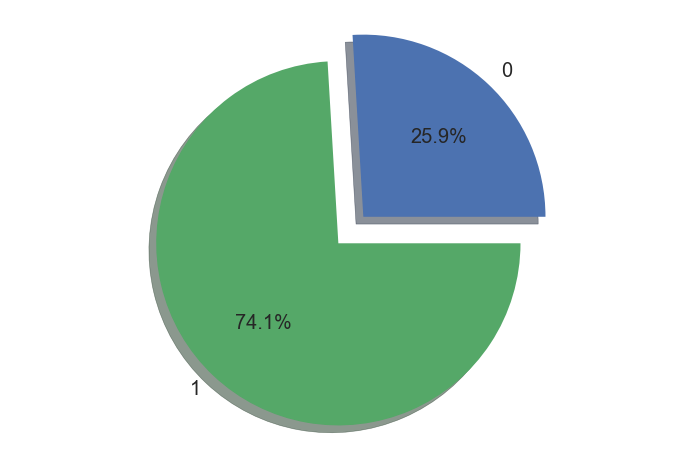

In [150]:
# Create a series to store the labels: y
y = df.case
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

In [151]:
analyser = SentimentIntensityAnalyzer()
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
print_sentiment_scores(df.loc[4,"message"])

NO!  You must pay for it yourself.  You were not born this way, it was your decision to change, now do NOT expect the American taxpayer to pick up the tab! {'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'compound': -0.6016}


In [152]:
df.loc[:,"sentiment_score"]=df.loc[:,"message"].apply(lambda x: analyser.polarity_scores(x).get('compound'))
df.loc[:,"sentiment_score"].head()

0    0.0000
1   -0.4983
2   -0.9393
3   -0.5882
4   -0.6016
Name: sentiment_score, dtype: float64

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


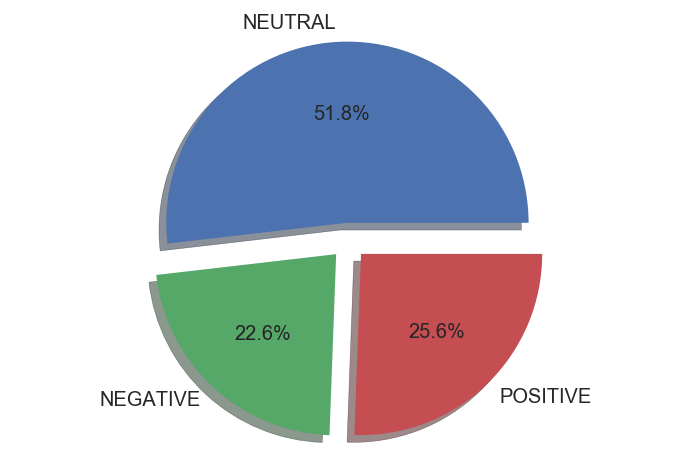

In [153]:
def assign_sentiment(x):
    if(x>=0.5):
        return "POSITIVE" 
    elif(x<=-0.5):
        return "NEGATIVE"
    else:
        return "NEUTRAL"
df.loc[:,"sentiment"]=df.loc[:,"sentiment_score"].apply(lambda x: assign_sentiment(x))
# Create a series to store the labels: y
preds=df.sentiment
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(preds)

In [154]:
pd.crosstab(df.case,df.sentiment, margins=True,normalize='index')

sentiment,NEGATIVE,NEUTRAL,POSITIVE
case,,,
0,0.344628,0.539683,0.115690
1,0.184151,0.510854,0.304994
All,0.225786,0.518334,0.255880


In [155]:
pd.crosstab(df.case,df.sentiment, margins=True,normalize='columns')

sentiment,NEGATIVE,NEUTRAL,POSITIVE,All
case,,,,
0,0.396001,0.27013,0.117301,0.259444
1,0.603999,0.72987,0.882699,0.740556


### We use the vaderSentiment package to re-label the dataset

** Main Conclusiones **

* We realize that the data has a lot of misslabel message, specially in the positive class.

* From the sample that we take, we know that we can spect between a 51% and a 30% of misslabel message depending if we consider three class (negative, positive and neutral) or only two (positive and negative)

* If we repeat this analysis using the sentiment score provided by the Vader package we should expect just 30% of error for the NEUTRAL class and 85% of accuracy for the three types of sentiments

* We have decided to use the sentiment score of the vader package to re-label the data and then use the all the previous approuch to train our classify model

** Where did we get this conclusions **

* After to take a look at the first 100 row , we saw a lot of sentences classifies as negative or positive that do not have a predominant feeling, necessarily. After compare the results of the vader package with the original data, we can see that the 51% of our data is classify as neutral.

* Also, we saw a lot miss classify data, especially in the positives. We took a sample of the first 50 rows labeled as NEUTRAL when we use the vader package criteria (vader score entre -0.5 y 0.5) and we label it manually. We found that 32% of the messages was miss labeled, but this was clearly concentrated in the texts that had been labeled as positive and should be negative. 

* It's important to notice that some topics has better accuracy, like abortion, but the others like the subjects related to the president or the NFL has the miss label problem for the negative sentences which are usually labeled as positive. 


* **Examples with first 50 rows between -0,5 and 0.5 in sentiment score using vader **

* Code to get the sample: df[df.sentiment=='NEUTRAL'].head(50)

    * Labels as positive when they should be negative:
        * index - meesage
        * 9  Hire your own shrink!!
        * 40 What does a queer know
        * 52 They're not for our country!!
        * 60 He should be man of the rear"...not year!
        * 62 Only people worse are the two faced NFL owners. They pick and chose who can act out
        * 63 He is so disrespectful of this country that he should move to Guatamala or somewhere similar.Just like the 
          rest of the kneelers.Can them all.What is wrong with you Goodell.Grow a pair.
        * 64 He is the disgrace of the year
        * 66 Just another example of the media and their far left garbage
        * 70 Gutless coward, will not be reading that piece of trash again
        * 71 Money talks an they think they are entitled
        * 72 Absolutely yes he's a idiot
        * 73 The creep of the year just look at his hair
        * 75 He's not worth talking about
        * 77 I'M DONE BUYING GQ MAGIZINE.WHAT WERE THEY THINKING.RACIEST
        * 80 He does'nt deserve anything, he started all the chaos about our flag. He is just a coward, yellow streak 
        down his back. He should be proud of his country, he sure got paid enough to play football for his country. He 
        is sick.
   
    * Labels as negative when they should be positive:
        * 76 Birds of a feather are idols together GQ and kaepernick.

    * Labels as negative or positive when they should be neutral:
        * 49 Is Hillary their lawyer ? (could be ironic in that case will be - and was labeled as +)


* To prevent that assume that this was a general situation only from a 50 sample, we took another 50 sample of the tail 
  part of the data, and this was the results:

* **Examples with last 50 rows between -0,5 and 0.5 in sentiment score using vader **

* Code to get the sample: df[df.sentiment=='NEUTRAL'].tail(50)

    * Labels as positive(1) when they should be negative:
        * index - meesage -sentiment_score from vader package
        * 12547  So Fked up and never covered on major networks!! 0
        * 12563. In real life people are held accountable for their actions.   This young sailor decided to ignore her 
        obligation and duty to her country.\nOne of her comments was, " the flag is just a flag and it really meant 
        nothing to her."   I find many of our younger generation feel the same: they have no feeling for the red, 
        white, and blue. -0.49
        * 1567 Why, is he having heart surgery? BECAUSE FIRST, one has to have a HEART! 0
        * 12570 Eat dirt Obama-Bin-lodin. -0.34
        * 12573 He is so good at criticizing others.  Now we learn that in real life he is just a big hypocrite! 0.3
        * 12574 The liberals can go screw themselves !! -0.3
        * 12580 She is a disgrace and should of got a  dishonorable discharge -0.49
        * 12589 Holder should be shitting his pants too..... He weponized the Justice Department.... 0.15
        * 12607 Lol. Poor baby didn't get his way -0.07
        * 12617 Didn't know what he was talking about in a gun shop & around firearms. In other words, he's just 
        another liberal dimwit. -0.34
        * 12619 I think that people in the three branches of government should be forced to take and pass economics 
        courses.  Might be interesting to see how these brainless plans would be changed. -0.07
        * 12620 So walk off the job, burn the store you work for down, then burn down all the other shops in the area. 
        GO DEMOCRATS GO 0
        * 12622 They know nothing about laws and history 0
        * 12624 "Obama couldn't get this done in 8 years.  It was never part of his agenda.  He did work diligently to 
        destroy the moral, economic and military fabric of this great nation 0.33

    * Labels as negative(0) when they should be positive:
        * NONE

    * Labels as negative or positive when they should be neutral:
        * 12539	 pelosi and Schumer need to school him before Hillary "offs" him.. 0
        * 12546  It was ok went Odumbass instituted PC verbiage in the military and almost all alphabet agencies but when Trump “un does “ all things Obama...the left freaks ....luv it!!! -0.22
        * Sounds like a payoff??? 0
        * 12559 He needs a visit from the secret service 0
        * 12561 Get her out of there...... 0
        * 12575 A wise man asks for God’s guidance. 0.4
        * 12581 Cut all US funding to the UN0 -0.33
        * 12583 Let's cancel the UN take back that fantastic real estate in NYC! 0.43
        * 12586 Within the law one either does it by the book (complying with all applicable laws) or the book gets 
          inserted in a most uncomfortable location! -0.49
        * 12591 Should be explaining to a jury. 0
        * 12593 She should be charged in due course -0.2
        * 12594 No Trump . Time Will tall . -0.29
        * 12603 This is a touchdown any other time 0
        * 12604 Nevr had possession of the ball 0
        * 12606 Dont blame the patriots,if your man can't catch, watch the ball bounce on replay, it's not a catch 0.25
        * 12608 This rule has been around for years and has effected other games.Rules are rules like them or not!!
        0.47
        * 12611 The funny thing is nowadays is that it\'s the white population that\'s finding it difficult to get a 
          job. We are sinking as the minority now. All the stigma that whites are "privledged" is dwindling. We not so 
          privledged afterall. I\'m seeing more whites homeless or in food pantry lines. 🤔🤔' 0.1
        * 12623 The ball crossed the plane, thus t.d.!!! 0
        * 12625 That's why most of them don't like him they stopped liking him when he said jobs jobs jobs -0.07


* As we can see, there is 14 mistakes in sentence which are classified as positive but are negative and 18 which are 
  labeled as positive or negative and should be neutral. If we take only the first type of mistakes, this will give us 
  a 18% of misslabeled data and if we use both types will be a 64%.

* If we use the sentiment score from the vader library, the misllabel data will a 30% 

* it's importance to notice that again, the topic of the conversation is very important and the kind of error rate is 
  different between topics: NFL topic is more likely to have neutral sentences and 

** Putting all together **

* If we assume there is only two type of sentiments, the data is misslabeled in a 30% in our sample

* If we asume there is three type of sentiments, the data misslabeled is 51% of the data

* we should expect a 30% of misslabel data in the NEUTRAL sentiment (which less than the 85% of accuracy presented in the paper, but it much better than our actual label) if we use the vader package to label the data with three type of sentiments using the following thresholds:
    * Negative if sentiment score equal or lower than 0.5
    * Positive if sentiment score is equal or greather than 0.5
    * Neutral in any other case  


** References for the Vader Package **

*<https://github.com/cjhutto/vaderSentiment>*

*<http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html>*

*<http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf>*

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


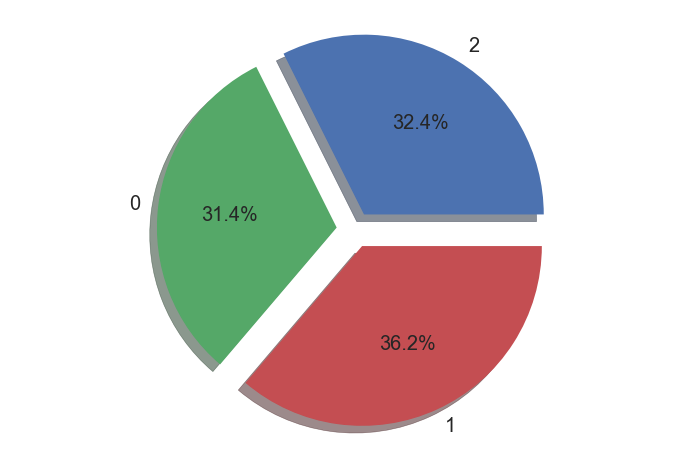

In [156]:
def assign_sentiment(x):
    if(x>=0.3):
        #return "POSITIVE"
        return 1 
    elif(x<=-0.3):
        #return "NEGATIVE"
        return 0
    else:
        #return "NEUTRAL"
        return 2
df.loc[:,"sentiment"]=df.loc[:,"sentiment_score"].apply(lambda x: assign_sentiment(x))
# Create a series to store the labels: y
preds=df.sentiment
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(preds)

In [157]:
pd.crosstab(df.case,df.sentiment, margins=True,normalize='columns')

sentiment,0,1,2,All
case,,,,
0,0.37623,0.140984,0.278797,0.259444
1,0.62377,0.859016,0.721203,0.740556


### Sampling and checking our threshold

* Accuracy excpected for our threshold by class:
    * Neutral:
    * Positive:
    * Negative:
    
* Accuracy expected:

#### Diccionario para la extracción, conteo y polaridad de emojis

*<https://github.com/words/emoji-emotion/blob/master/index.json>*

In [158]:
emoji_list=[
       {
        "name": "100",
        "emoji": "💯",
        "polarity": 3
       },
       {
        "name": "angry",
        "emoji": "😠",
        "polarity": -3
       },
       {
        "name": "anguished",
        "emoji": "😧",
        "polarity": -3
      },
      {
        "name": "astonished",
        "emoji": "😲",
        "polarity": 2
      },
      {
        "name": "black_heart",
        "emoji": "🖤",
        "polarity": 3
      },
      {
        "name": "blue_heart",
        "emoji": "💙",
        "polarity": 3
      },
      {
        "name": "blush",
        "emoji": "😊",
        "polarity": 2
      },
      {
        "name": "broken_heart",
        "emoji": "💔",
        "polarity": -3
      },
      {
        "name": "clap",
        "emoji": "👏",
        "polarity": 3
      },
      {
        "name": "clown_face",
        "emoji": "🤡",
        "polarity": 0
      },
      {
        "name": "cold_sweat",
        "emoji": "😰",
        "polarity": -2
      },
      {
        "name": "confounded",
        "emoji": "😖",
        "polarity": -2
      },
      {
        "name": "confused",
        "emoji": "😕",
        "polarity": -2
      },
      {
        "name": "cowboy_hat_face",
        "emoji": "🤠",
        "polarity": 2
      },
      {
        "name": "crossed_fingers",
        "emoji": "🤞",
        "polarity": 2
      },
      {
        "name": "cry",
        "emoji": "😢",
        "polarity": -2
      },
      {
        "name": "crying_cat_face",
        "emoji": "😿",
        "polarity": -2
      },
      {
        "name": "cupid",
        "emoji": "💘",
        "polarity": 3
      },
      {
        "name": "disappointed",
        "emoji": "😞",
        "polarity": -2
      },
      {
        "name": "disappointed_relieved",
        "emoji": "😥",
        "polarity": -1
      },
      {
        "name": "dizzy_face",
        "emoji": "😵",
        "polarity": -1
      },
      {
        "name": "drooling_face",
        "emoji": "🤤",
        "polarity": 0
      },
      {
        "name": "expressionless",
        "emoji": "😑",
        "polarity": 0
      },
      {
        "name": "face_with_head_bandage",
        "emoji": "🤕",
        "polarity": -2
      },
      {
        "name": "face_with_thermometer",
        "emoji": "🤒",
        "polarity": -1
      },
      {
        "name": "fearful",
        "emoji": "😨",
        "polarity": -2
      },
      {
        "name": "flushed",
        "emoji": "😳",
        "polarity": -2
      },
      {
        "name": "frowning",
        "emoji": "😦",
        "polarity": -1
      },
      {
        "name": "frowning_face",
        "emoji": "☹️",
        "polarity": -2
      },
      {
        "name": "fu",
        "emoji": "🖕",
        "polarity": -4
      },
      {
        "name": "ghost",
        "emoji": "👻",
        "polarity": -1
      },
      {
        "name": "gift_heart",
        "emoji": "💝",
        "polarity": 3
      },
      {
        "name": "green_heart",
        "emoji": "💚",
        "polarity": 3
      },
      {
        "name": "grimacing",
        "emoji": "😬",
        "polarity": -2
      },
      {
        "name": "grin",
        "emoji": "😁",
        "polarity": 2
      },
      {
        "name": "grinning",
        "emoji": "😀",
        "polarity": 2
      },
      {
        "name": "handshake",
        "emoji": "🤝",
        "polarity": 1
      },
      {
        "name": "heart",
        "emoji": "❤️",
        "polarity": 3
      },
      {
        "name": "heart_eyes",
        "emoji": "😍",
        "polarity": 3
      },
      {
        "name": "heart_eyes_cat",
        "emoji": "😻",
        "polarity": 3
      },
      {
        "name": "heartbeat",
        "emoji": "💓",
        "polarity": 3
      },
      {
        "name": "heartpulse",
        "emoji": "💗",
        "polarity": 3
      },
      {
        "name": "hugs",
        "emoji": "🤗",
        "polarity": 2
      },
      {
        "name": "hushed",
        "emoji": "😯",
        "polarity": -1
      },
      {
        "name": "imp",
        "emoji": "👿",
        "polarity": -4
      },
      {
        "name": "innocent",
        "emoji": "😇",
        "polarity": 3
      },
      {
        "name": "joy",
        "emoji": "😂",
        "polarity": 3
      },
      {
        "name": "joy_cat",
        "emoji": "😹",
        "polarity": 3
      },
      {
        "name": "kiss",
        "emoji": "💋",
        "polarity": 2
      },
      {
        "name": "kissing",
        "emoji": "😗",
        "polarity": 2
      },
      {
        "name": "kissing_cat",
        "emoji": "😽",
        "polarity": 2
      },
      {
        "name": "kissing_closed_eyes",
        "emoji": "😚",
        "polarity": 2
      },
      {
        "name": "kissing_heart",
        "emoji": "😘",
        "polarity": 3
      },
      {
        "name": "kissing_smiling_eyes",
        "emoji": "😙",
        "polarity": 2
      },
      {
        "name": "laughing",
        "emoji": "😆",
        "polarity": 1
      },
      {
        "name": "lips",
        "emoji": "👄",
        "polarity": 2
      },
      {
        "name": "lying_face",
        "emoji": "🤥",
        "polarity": -2
      },
      {
        "name": "mask",
        "emoji": "😷",
        "polarity": -1
      },
      {
        "name": "money_mouth_face",
        "emoji": "🤑",
        "polarity": 0
      },
      {
        "name": "nauseated_face",
        "emoji": "🤢",
        "polarity": -2
      },
      {
        "name": "nerd_face",
        "emoji": "🤓",
        "polarity": -1
      },
      {
        "name": "neutral_face",
        "emoji": "😐",
        "polarity": 0
      },
      {
        "name": "no_mouth",
        "emoji": "😶",
        "polarity": 0
      },
      {
        "name": "ok_hand",
        "emoji": "👌",
        "polarity": 2
      },
      {
        "name": "open_mouth",
        "emoji": "😮",
        "polarity": -2
      },
      {
        "name": "pensive",
        "emoji": "😔",
        "polarity": -1
      },
      {
        "name": "persevere",
        "emoji": "😣",
        "polarity": -2
      },
      {
        "name": "pouting_cat",
        "emoji": "😾",
        "polarity": -4
      },
      {
        "name": "pray",
        "emoji": "🙏",
        "polarity": 1
      },
      {
        "name": "punch",
        "emoji": "👊",
        "polarity": -1
      },
      {
        "name": "purple_heart",
        "emoji": "💜",
        "polarity": 3
      },
      {
        "name": "rage",
        "emoji": "😡",
        "polarity": -4
      },
      {
        "name": "raised_hands",
        "emoji": "🙌",
        "polarity": 4
      },
      {
        "name": "relaxed",
        "emoji": "☺️",
        "polarity": 2
      },
      {
        "name": "relieved",
        "emoji": "😌",
        "polarity": 2
      },
      {
        "name": "revolving_hearts",
        "emoji": "💞",
        "polarity": 3
      },
      {
        "name": "rofl",
        "emoji": "🤣",
        "polarity": 4
      },
      {
        "name": "roll_eyes",
        "emoji": "🙄",
        "polarity": -1
      },
      {
        "name": "scream",
        "emoji": "😱",
        "polarity": -3
      },
      {
        "name": "scream_cat",
        "emoji": "🙀",
        "polarity": -3
      },
      {
        "name": "shit",
        "emoji": "💩",
        "polarity": -3
      },
      {
        "name": "skull",
        "emoji": "💀",
        "polarity": -2
      },
      {
        "name": "skull_and_crossbones",
        "emoji": "☠️",
        "polarity": -2
      },
      {
        "name": "sleeping",
        "emoji": "😴",
        "polarity": 0
      },
      {
        "name": "sleepy",
        "emoji": "😪",
        "polarity": 0
      },
      {
        "name": "slightly_frowning_face",
        "emoji": "🙁",
        "polarity": -1
      },
      {
        "name": "slightly_smiling_face",
        "emoji": "🙂",
        "polarity": 1
      },
      {
        "name": "smile",
        "emoji": "😄",
        "polarity": 2
      },
      {
        "name": "smile_cat",
        "emoji": "😸",
        "polarity": 2
      },
      {
        "name": "smiley",
        "emoji": "😃",
        "polarity": 2
      },
      {
        "name": "smiley_cat",
        "emoji": "😺",
        "polarity": 2
      },
      {
        "name": "smiling_imp",
        "emoji": "😈",
        "polarity": -3
      },
      {
        "name": "smirk",
        "emoji": "😏",
        "polarity": 2
      },
      {
        "name": "smirk_cat",
        "emoji": "😼",
        "polarity": 2
      },
      {
        "name": "sneezing_face",
        "emoji": "🤧",
        "polarity": -2
      },
      {
        "name": "sob",
        "emoji": "😭",
        "polarity": -3
      },
      {
        "name": "sparkling_heart",
        "emoji": "💖",
        "polarity": 3
      },
      {
        "name": "stuck_out_tongue",
        "emoji": "😛",
        "polarity": 1
      },
      {
        "name": "stuck_out_tongue_closed_eyes",
        "emoji": "😝",
        "polarity": 0
      },
      {
        "name": "stuck_out_tongue_winking_eye",
        "emoji": "😜",
        "polarity": -1
      },
      {
        "name": "sunglasses",
        "emoji": "😎",
        "polarity": 1
      },
      {
        "name": "sweat",
        "emoji": "😓",
        "polarity": -1
      },
      {
        "name": "sweat_smile",
        "emoji": "😅",
        "polarity": 2
      },
      {
        "name": "thinking",
        "emoji": "🤔",
        "polarity": -1
      },
      {
        "name": "thumbsdown",
        "emoji": "👎",
        "polarity": -2
      },
      {
        "name": "thumbsup",
        "emoji": "👍",
        "polarity": 2
      },
      {
        "name": "tired_face",
        "emoji": "😫",
        "polarity": -2
      },
      {
        "name": "triumph",
        "emoji": "😤",
        "polarity": 0
      },
      {
        "name": "two_hearts",
        "emoji": "💕",
        "polarity": 3
      },
      {
        "name": "unamused",
        "emoji": "😒",
        "polarity": -2
      },
      {
        "name": "upside_down_face",
        "emoji": "🙃",
        "polarity": 0
      },
      {
        "name": "v",
        "emoji": "✌️",
        "polarity": 2
      },
      {
        "name": "weary",
        "emoji": "😩",
        "polarity": -2
      },
      {
        "name": "wink",
        "emoji": "😉",
        "polarity": 3
      },
      {
        "name": "worried",
        "emoji": "😟",
        "polarity": -3
      },
      {
        "name": "yellow_heart",
        "emoji": "💛",
        "polarity": 3
      },
      {
        "name": "yum",
        "emoji": "😋",
        "polarity": 3
      },
      {
        "name": "zipper_mouth_face",
        "emoji": "🤐",
        "polarity": -1
      }
]

## Pre-processing

### Extract the information from the emojis in the text

* emoji's polarity
* Númber of positive emojis
* Number of negative emojis

* References:
    *<https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text/48376256#48376256>*

In [27]:
df.loc[:,"emojis_polarity"]=df.loc[:,"message"].apply(lambda x: extract_emojis_polarity(x).copy())
df.loc[:,"n_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len(x)).copy()
df.loc[:,"negative_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len([p for p in x if(p<0)])).copy()
df.loc[:,"positive_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len([p for p in x if(p>0)])).copy()
df.emojis_polarity=df.emojis_polarity.apply(lambda x: x[0] if (len(x)>0) else 0)

In [28]:
df[(df.negative_emojis>0) |(df.positive_emojis>0)].shape

(335, 8)

### Clean text using regex

In [29]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: cleanText(x)).copy()
df[(df.emojis_polarity!=0)].shape

(335, 9)

### Add the negation marking to the words and create the variable numbers of negations

In [30]:
negation_finder=re.compile(r"""(never|nothing|nowhere|noone|none|not|no|havent|hasnt|hadnt|cant|couldnt|shouldnt|
wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)""",flags=re.I | re.X | re.MULTILINE )
clp_finder=re.compile(r"""[,.:;!?]""",flags=re.I | re.X | re.MULTILINE )
df.loc[:,"n_negation"]=df.message.apply(lambda x: negation_finder.subn('',x)[1])

In [31]:
df.loc[:,"clean_message_neg"]=df.loc[:,"clean_message"].apply(
    lambda x: negation_marks(x,clp_finder,negation_finder) if (clp_finder.findall(x)==[]) 
    else negation_3_words_rules(x,clp_finder,negation_finder)).copy()

In [32]:
df.loc[1500,"clean_message"]

'Bunch of damn idiots, he got a drink of water, who the hell cares!!!!! I hope next time he has ice cream he gets @NUMBER  scoops and all these damn fools pass the hell out, I ve never seen more idiotic people in my @NUMBER  years on this earth! I m going to call and see if our President will talk to me and ask him not to eat or drink in front of those fools ever again, they might have a heart attack and some asshole will accuse him of murder!!!'

In [33]:
df.loc[1500,"clean_message_neg"]

'Bunch of damn idiots  he got a drink of water  who the hell cares      I hope next time he has ice cream he gets  NUMBER scoops and all these damn fools pass the hell out  I ve never_NEG seen_NEG more_NEG idiotic_NEG people in my  NUMBER years on this earth  I m going to call and see if our President will talk to me and ask him not_NEG to_NEG eat_NEG or_NEG drink in front of those fools ever again  they might have a heart attack and some asshole will accuse him of murder    '

In [99]:
df.loc[1500,:]

case                                                                 2
message              Bunch of damn idiots, he got a drink of water,...
sentiment_score                                                -0.9793
sentiment                                                            2
emojis_polarity                                                      0
n_emojis                                                             0
negative_emojis                                                      0
positive_emojis                                                      0
clean_message        Bunch of damn idiots, he got a drink of water,...
n_negation                                                           2
clean_message_neg    Bunch of damn idiots  he got a drink of water ...
n_words                                                             90
n_exclamations                                                       9
n_questions                                                          0
n_capi

### Create some cool features that may be useful (we will figure it out)

* For each row in the datset we will get the following numercial features:
    * Number of words with the variable name n_words
    * Number of sentences with the variable name n_sentences
    * Number of entities with the variable name n_entities
    * Number of words writen with only capitals letters with the variable name n_capitals
    * Number of exclamations (! or ¡) with the variable name n_exclamations
    * Number of ask signs (? or ¿) with the variable name n_ask_signs
    * The number of qualifier adjectives in the sentence as n_adj Example: '*mentally ill* person'
    * The number of verbs in the sentence as n_verbs

In [34]:
df.loc[:,"n_words"]=df.loc[:,"message"].apply(lambda x: len(x.split())).copy()
df.loc[:,"n_exclamations"]=df.loc[:,"message"].apply(lambda x: count_exclamations(x)).copy()
df.loc[:,"n_questions"]=df.loc[:,"message"].apply(lambda x: count_questions(x)).copy()
df.loc[:,"n_capitals"]=df.loc[:,"clean_message"].apply(lambda x: count_capital(x)).copy()
df.loc[:,"n_sentences"]=df.loc[:,"message"].apply(lambda x: count_sentences(doc=x,parser=parser)).copy()
df.loc[:,"entities"]=df.loc[:,"message"].apply(lambda x: get_entities(doc=x,parser=parser)).copy()
df.loc[:,"n_entities"]=df.loc[:,"entities"].apply(lambda x: len(x)).copy()
df.loc[:,"n_adj"]=df.loc[:,"clean_message"].apply(lambda x: n_adj(doc=x,parser=parser)).copy()
df.loc[:,"n_verbs"]=df.loc[:,"clean_message"].apply(lambda x: n_verbs(doc=x,parser=parser)).copy()

In [35]:
backup=df

In [36]:
df.to_csv('df_vader.csv',encoding='utf-8',sep=';')

### Explore the relation between our numerical features and the target, and also between them

In [37]:
df.loc[:,"case"]=df.loc[:,"sentiment_score"].apply(lambda x: assign_sentiment(x))

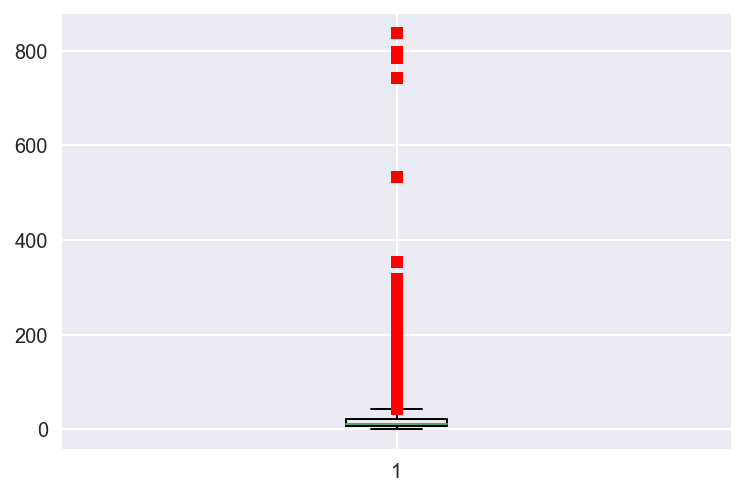

In [38]:
plt.boxplot(df.n_words,0,'rs');

       count       mean        std  min  25%   50%   75%    max
case                                                           
0     4089.0  12.733920  11.694920  1.0  6.0   9.0  15.0  134.0
1     4575.0  19.275847  25.973044  2.0  7.0  12.0  22.0  797.0
2     3963.0  23.653798  34.629878  2.0  9.0  15.0  27.0  836.0


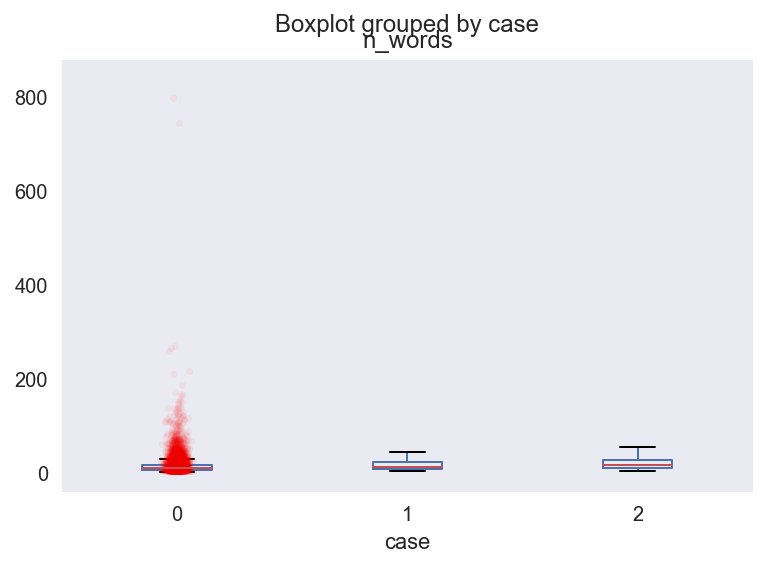

In [39]:
print(df.groupby('case')['n_words'].describe())
bp = df.boxplot(column='n_words',by='case',grid=False)
for i in [0,1]:
    y = df.n_words[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

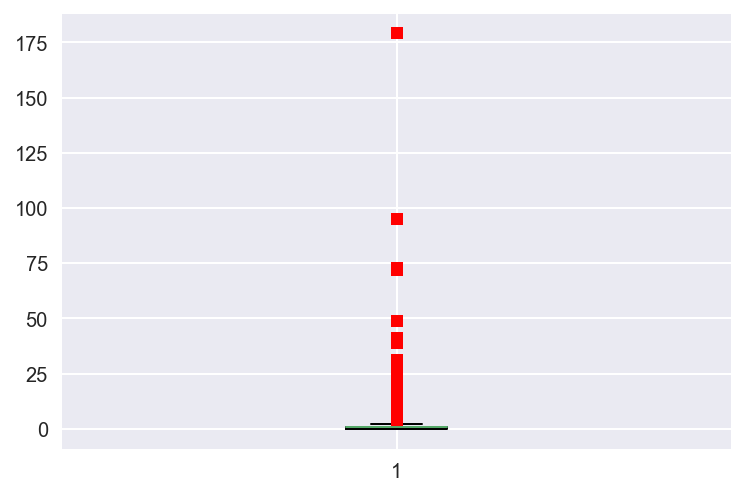

In [40]:
plt.boxplot(df.n_entities,0,'rs');

       count      mean       std  min  25%  50%  75%    max
case                                                       
0     4089.0  0.783077  1.232568  0.0  0.0  0.0  1.0   19.0
1     4575.0  1.166995  2.395997  0.0  0.0  1.0  2.0   95.0
2     3963.0  1.240474  3.910270  0.0  0.0  1.0  2.0  179.0


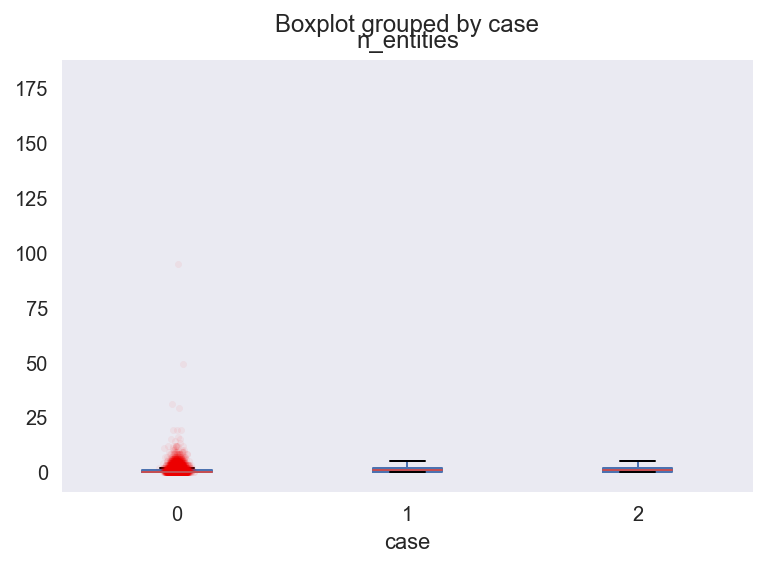

In [41]:
print(df.groupby('case')['n_entities'].describe())
bp = df.boxplot(column='n_entities',by='case',grid=False)
for i in [0,1]:
    y = df.n_entities[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

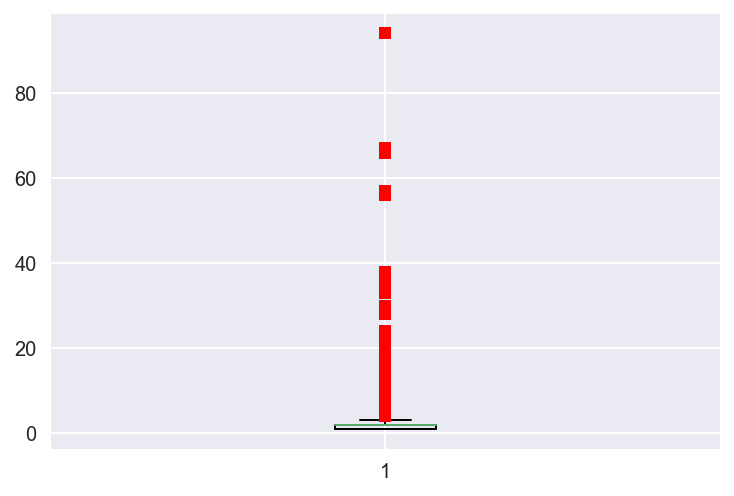

In [42]:
plt.boxplot(df.n_sentences,0,'rs');

       count      mean       std  min  25%  50%  75%   max
case                                                      
0     4089.0  1.644167  1.248018  1.0  1.0  1.0  2.0  30.0
1     4575.0  2.254645  2.269662  1.0  1.0  2.0  3.0  57.0
2     3963.0  2.461267  3.071864  1.0  1.0  2.0  3.0  94.0


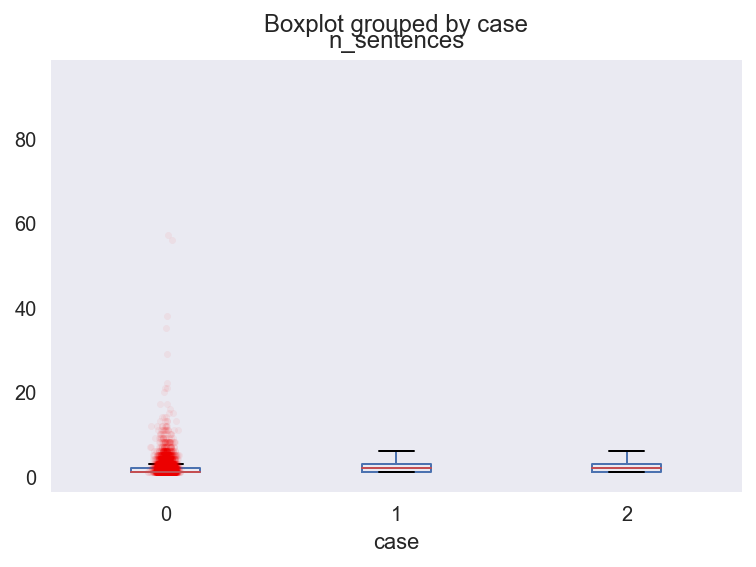

In [43]:
print(df.groupby('case')['n_sentences'].describe())
bp = df.boxplot(column='n_sentences',by='case',grid=False)
for i in [0,1]:
    y = df.n_sentences[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

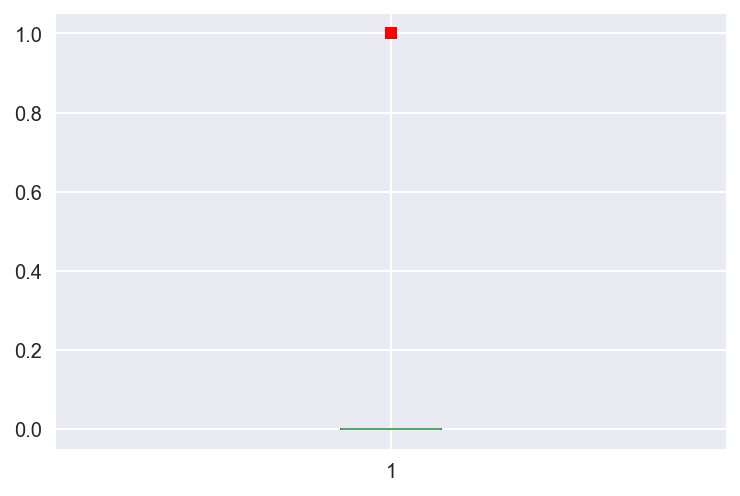

In [44]:
plt.boxplot(df.n_emojis,0,'rs');

      count  mean  std  min  25%  50%  75%  max
case                                           
0     115.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
1     141.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2      88.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0


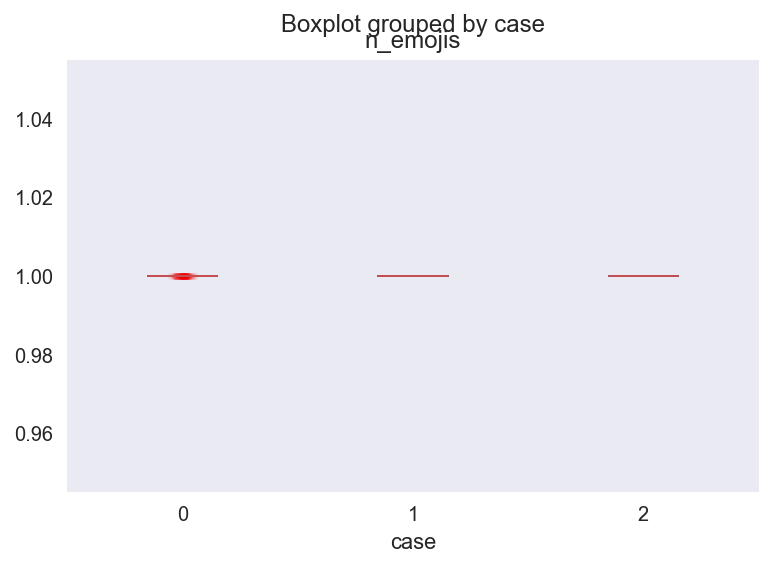

In [45]:
print(df[(df.n_emojis>0)].groupby('case')['n_emojis'].describe())
bp = df[(df.n_emojis>0)].boxplot(column='n_emojis',by='case',grid=False)
for i in [0,1]:
    y = df[(df.n_emojis>0)].n_emojis[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

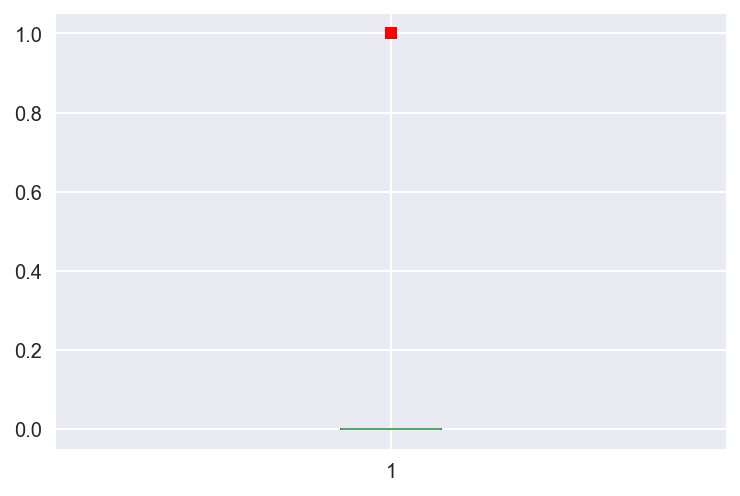

In [46]:
plt.boxplot(df.negative_emojis,0,'rs');

      count      mean       std  min  25%  50%  75%  max
case                                                    
0     113.0  0.477876  0.501735  0.0  0.0  0.0  1.0  1.0
1     137.0  0.248175  0.433539  0.0  0.0  0.0  0.0  1.0
2      85.0  0.682353  0.468324  0.0  0.0  1.0  1.0  1.0


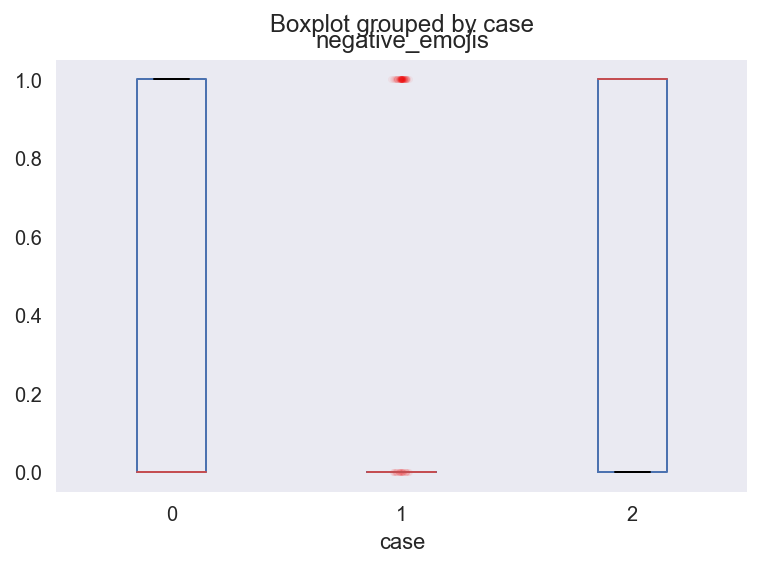

In [47]:
print(df[(df.emojis_polarity!=0)].groupby('case')['negative_emojis'].describe())
bp = df[(df.emojis_polarity!=0)].boxplot(column='negative_emojis',by='case',grid=False)
for i in [0,2]:
    y = df[(df.emojis_polarity!=0)].negative_emojis[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

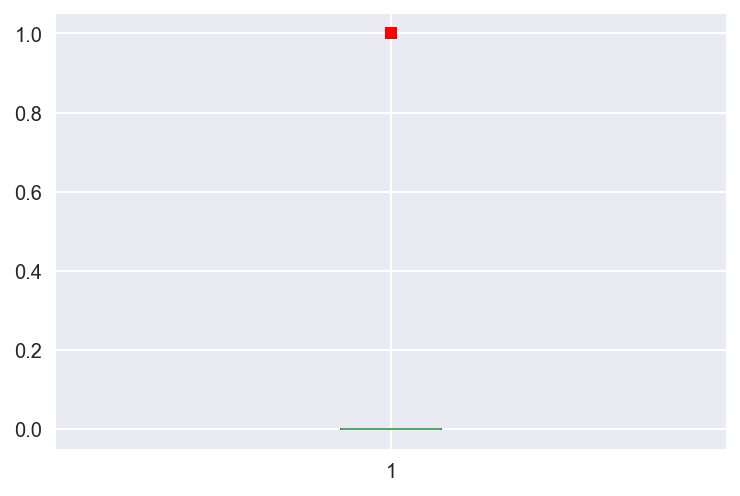

In [48]:
plt.boxplot(df.positive_emojis,0,'rs');

      count      mean       std  min  25%  50%  75%  max
case                                                    
0     113.0  0.522124  0.501735  0.0  0.0  1.0  1.0  1.0
1     137.0  0.751825  0.433539  0.0  1.0  1.0  1.0  1.0
2      85.0  0.317647  0.468324  0.0  0.0  0.0  1.0  1.0


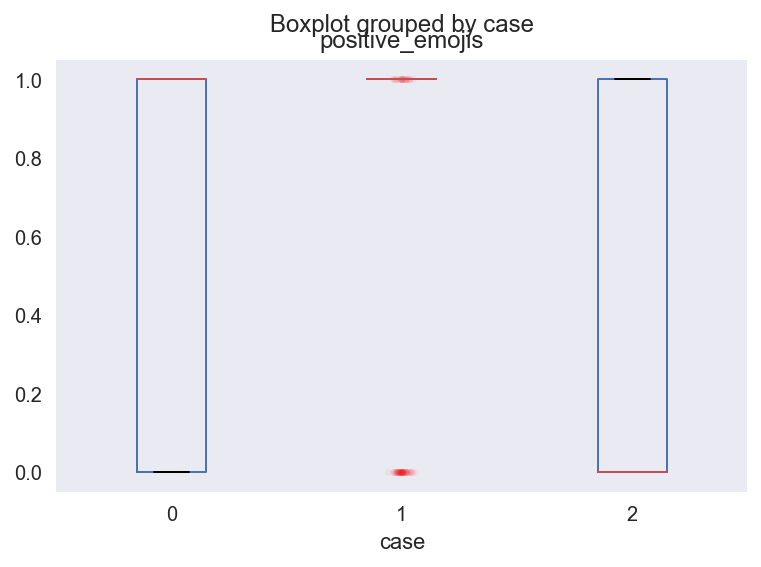

In [49]:
print(df[(df.emojis_polarity!=0)].groupby('case')['positive_emojis'].describe())
bp = df[(df.emojis_polarity!=0)].boxplot(column='positive_emojis',by='case',grid=False)
for i in [0,2]:
    y = df[(df.emojis_polarity!=0)].positive_emojis[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

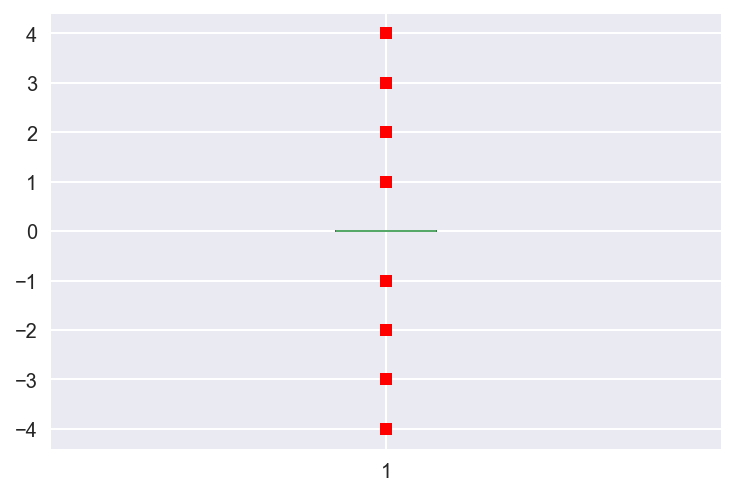

In [50]:
plt.boxplot(df.emojis_polarity,0,'rs');

      count      mean       std  min  25%  50%  75%  max
case                                                    
0     113.0 -0.079646  2.686413 -4.0 -3.0  1.0  2.0  4.0
1     137.0  1.058394  2.331897 -4.0  1.0  2.0  3.0  4.0
2      85.0 -1.329412  2.624918 -4.0 -4.0 -2.0  1.0  4.0


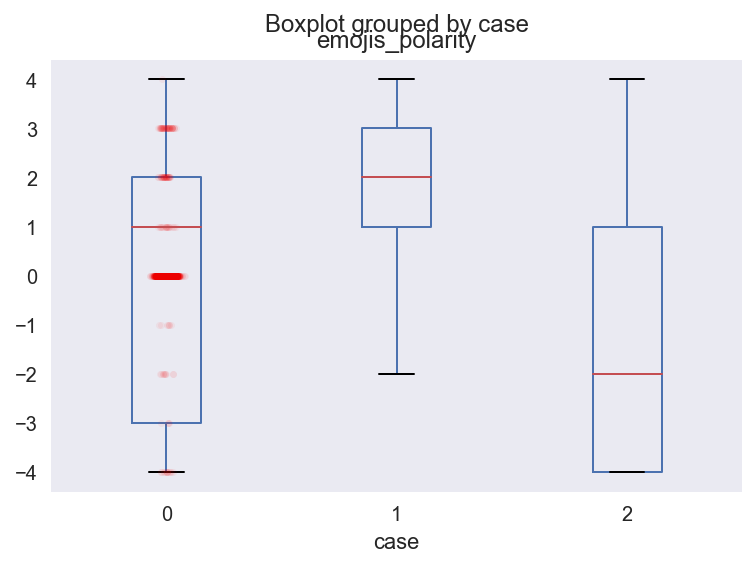

In [51]:
print(df[(df.emojis_polarity!=0)].groupby('case')['emojis_polarity'].describe())
bp = df[(df.emojis_polarity!=0)].boxplot(column='emojis_polarity',by='case',grid=False)
for i in [0,1]:
    y = df.emojis_polarity[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

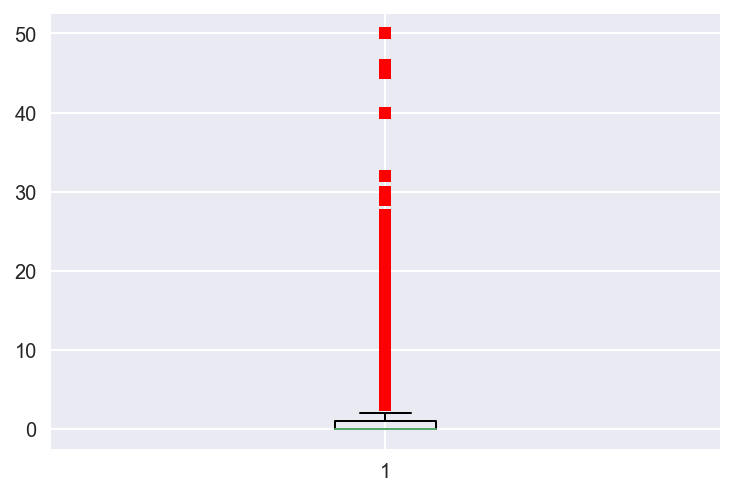

In [52]:
plt.boxplot(df.n_exclamations,0,'rs');

       count      mean       std  min  25%  50%  75%   max
case                                                      
0      959.0  2.454640  3.398357  1.0  1.0  1.0  3.0  50.0
1     1613.0  2.830130  3.130481  1.0  1.0  2.0  3.0  46.0
2     1333.0  2.964741  3.224733  1.0  1.0  2.0  4.0  46.0


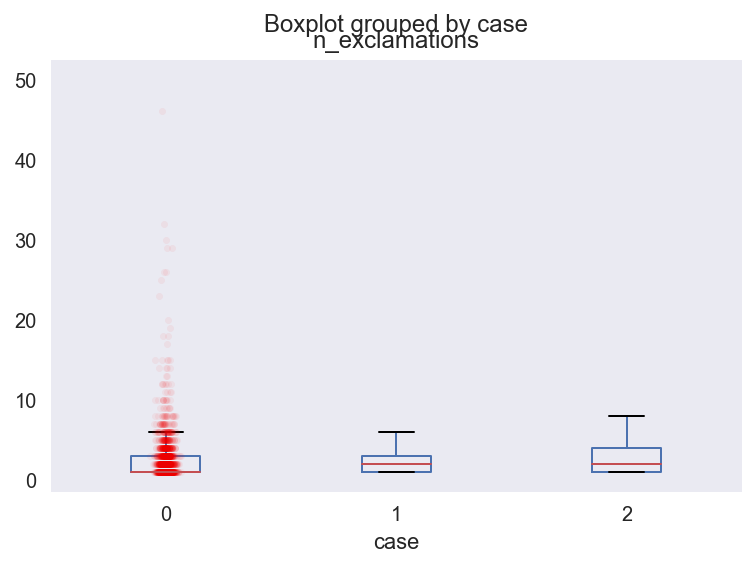

In [53]:
print(df[df.n_exclamations>0].groupby('case')['n_exclamations'].describe())
bp = df[df.n_exclamations>0].boxplot(column='n_exclamations',by='case',grid=False)
for i in [0,1]:
    y = df[df.n_exclamations>0].n_exclamations[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

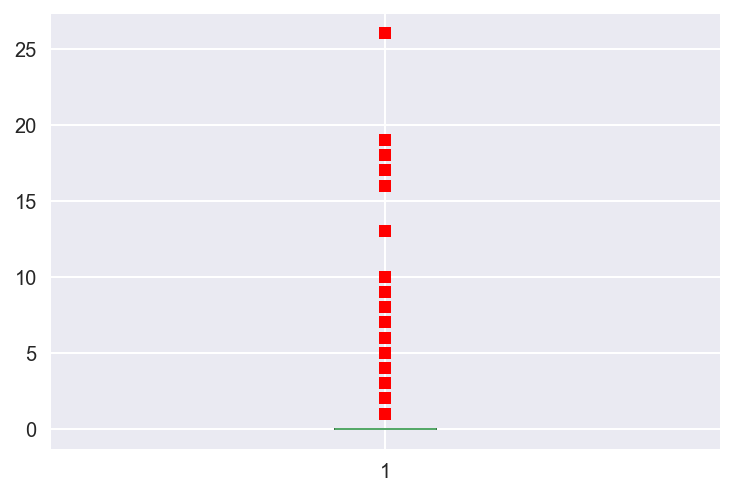

In [54]:
plt.boxplot(df.n_questions,0,'rs');

      count      mean       std  min  25%  50%  75%   max
case                                                     
0     366.0  1.685792  1.852703  1.0  1.0  1.0  1.0  18.0
1     288.0  1.881944  1.421569  1.0  1.0  1.0  2.0   9.0
2     468.0  2.079060  2.193076  1.0  1.0  1.0  2.0  26.0


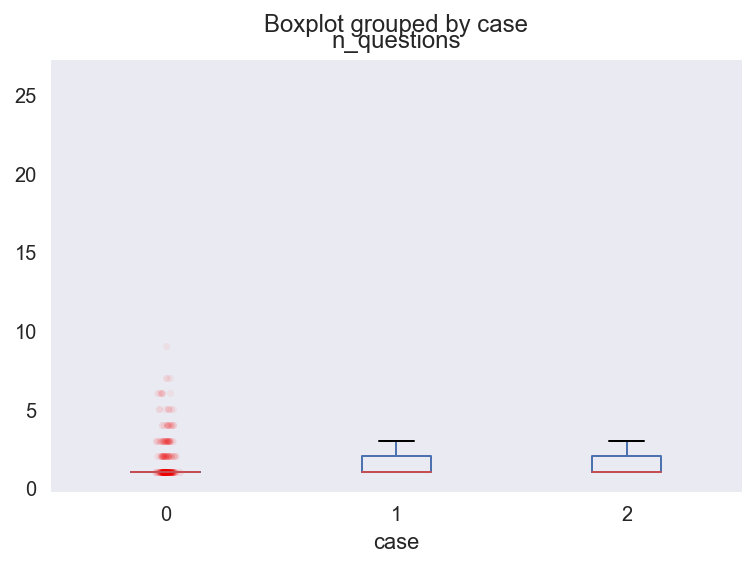

In [55]:
print(df[df.n_questions>0].groupby('case')['n_questions'].describe())
bp = df[df.n_questions>0].boxplot(column='n_questions',by='case',grid=False)
for i in [0,1]:
    y = df[df.n_questions>0].n_questions[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

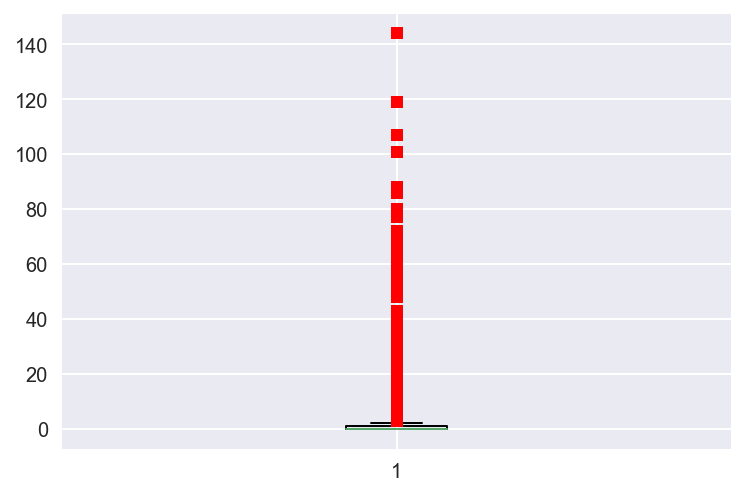

In [56]:
plt.boxplot(df.n_capitals,0,'rs');

       count      mean       std  min  25%  50%  75%    max
case                                                       
0     1612.0  2.348635  2.876311  1.0  1.0  1.0  2.0   26.0
1     2163.0  3.387425  7.443383  1.0  1.0  1.0  3.0  144.0
2     1912.0  3.869247  7.720365  1.0  1.0  2.0  3.0  107.0


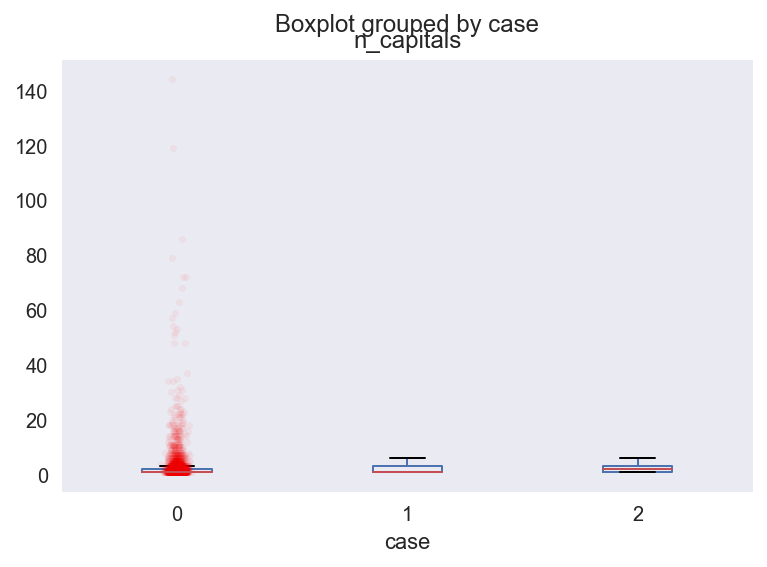

In [57]:
print(df[df.n_capitals>0].groupby('case')['n_capitals'].describe())
bp = df[df.n_capitals>0].boxplot(column='n_capitals',by='case',grid=False)
for i in [0,1]:
    y = df[df.n_capitals>0].n_capitals[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

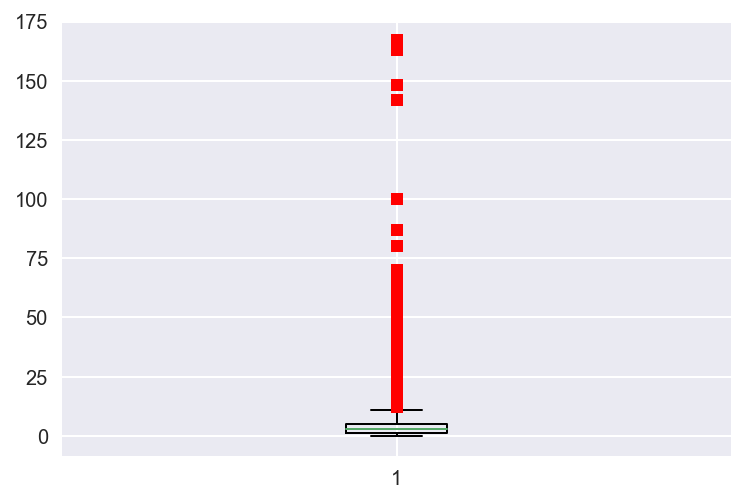

In [58]:
plt.boxplot(df.n_verbs,0,'rs');

       count      mean       std  min  25%  50%  75%    max
case                                                       
0     4089.0  3.107606  3.148193  0.0  1.0  2.0  4.0   45.0
1     4575.0  4.253989  5.877128  0.0  1.0  3.0  5.0  163.0
2     3963.0  5.449659  7.661252  0.0  2.0  4.0  7.0  167.0


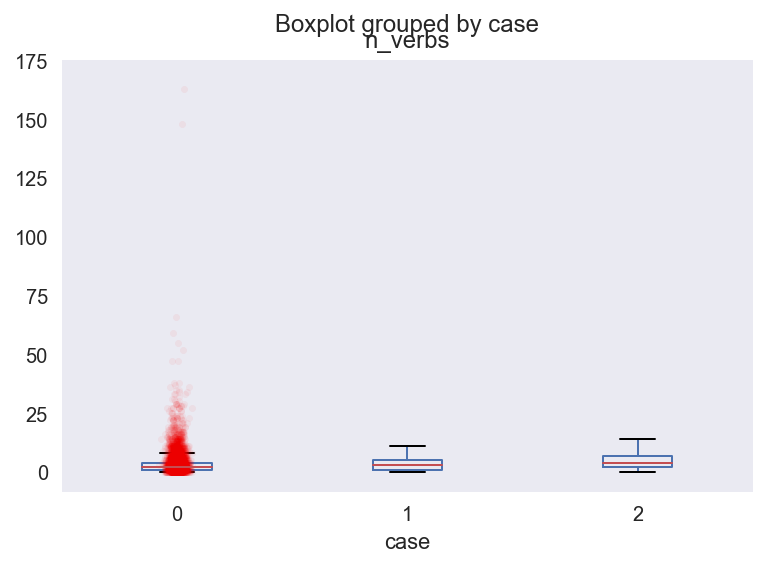

In [59]:
print(df.groupby('case')['n_verbs'].describe())
bp = df.boxplot(column='n_verbs',by='case',grid=False)
for i in [0,1]:
    y = df.n_verbs[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

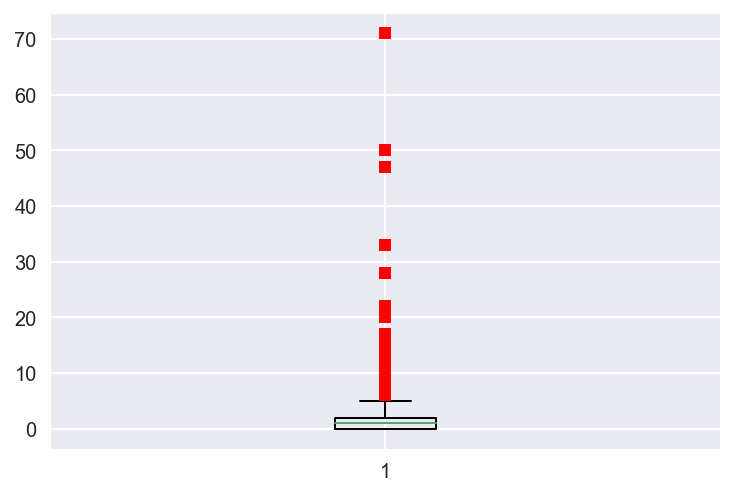

In [60]:
plt.boxplot(df.n_adj,0,'rs');

       count      mean       std  min  25%  50%  75%   max
case                                                      
0     1772.0  1.628668  1.103780  1.0  1.0  1.0  2.0  10.0
1     3084.0  2.038586  2.066712  1.0  1.0  1.0  2.0  50.0
2     2737.0  2.359883  2.836976  1.0  1.0  2.0  3.0  71.0


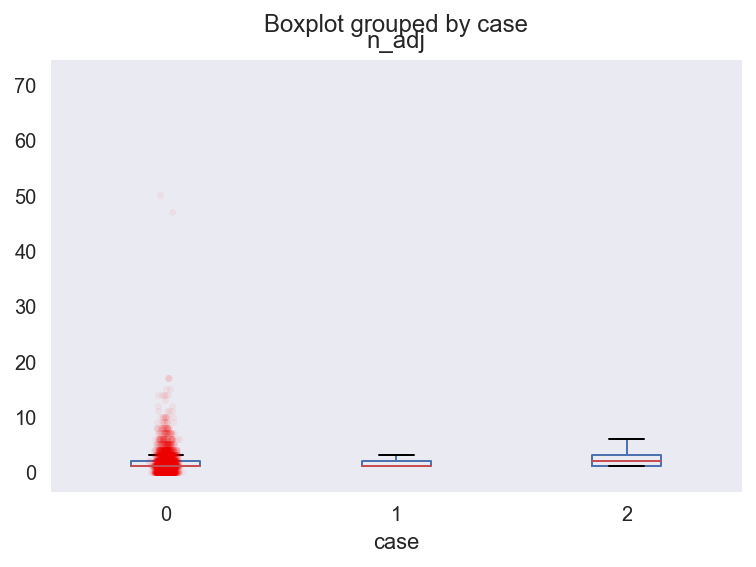

In [61]:
print(df[df.n_adj>0].groupby('case')['n_adj'].describe())
bp = df[df.n_adj>0].boxplot(column='n_adj',by='case',grid=False)
for i in [0,1]:
    y = df.n_adj[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

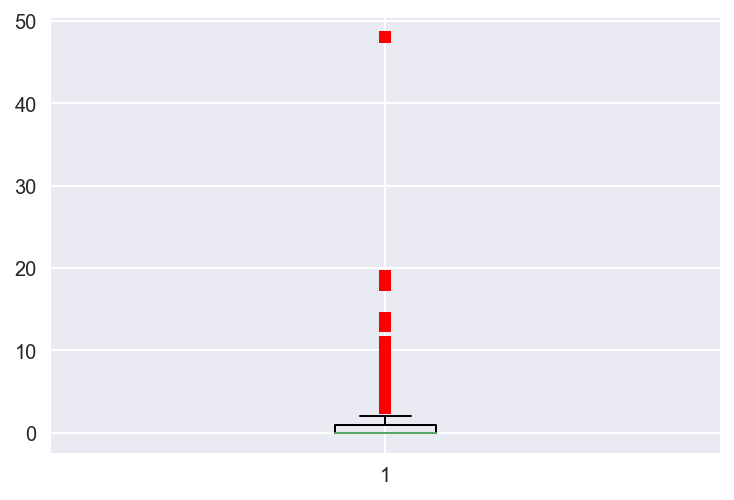

In [62]:
plt.boxplot(df.n_negation,0,'rs');

       count      mean       std  min  25%  50%  75%   max
case                                                      
0     1128.0  1.297872  0.610406  1.0  1.0  1.0  1.0   6.0
1     1192.0  1.529362  1.166627  1.0  1.0  1.0  2.0  14.0
2     1568.0  1.669005  1.831653  1.0  1.0  1.0  2.0  48.0


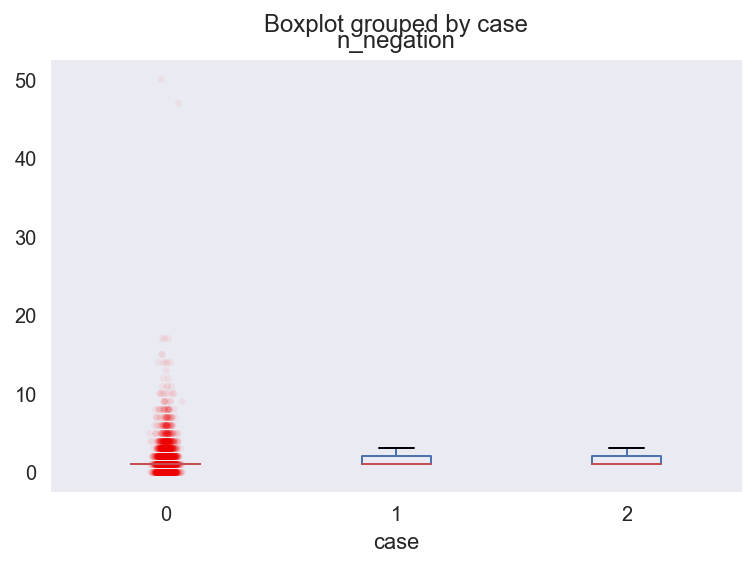

In [63]:
print(df[df.n_negation>0].groupby('case')['n_negation'].describe())
bp = df[df.n_negation>0].boxplot(column='n_negation',by='case',grid=False)
for i in [0,1]:
    y = df.n_adj[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05);

In [64]:
def scatter_with_color_dimension_graph(feature, target, layout_labels):
    """
    Scatter with color dimension graph to visualize the density of the
    Given feature with target
    :param feature:
    :param target:
    :param layout_labels:
    :return:
    """
    trace1 = go.Scatter(
        y=feature,
        mode='markers',
        marker=dict(
            size='16',
            color=target,
            colorscale='Viridis',
            showscale=True
        )
    )
    layout = go.Layout(
        title=layout_labels[2],
        xaxis=dict(title=layout_labels[0]), yaxis=dict(title=layout_labels[1]))
    data = [trace1]
    fig = Figure(data=data, layout=layout)
    # plot_url = py.plot(fig)
    py.image.save_as(fig, filename=layout_labels[1] + '_Density.png')

In [65]:
def main():
    
    print("data_RI :: ", list(df["case"][:10]))
    print("target :: ", np.array(['NEGATIVE','NEGATIVE','NEGATIVE','NEGATIVE','NEGATIVE','NEUTRAL','POSITIVE',
                                 'NEUTRAL','NEGATIVE','NEUTRAL']))
    # Graph Labels
    graph_labels = ["Number of Observations", "RI & Glass Type", "Sample RI - Glass Type Density Graph"]
 
    scatter_with_color_dimension_graph(list(df["case"][:10]),
                                       np.array(['NEGATIVE','NEGATIVE','NEGATIVE','NEGATIVE','NEGATIVE','NEUTRAL',
                                                 'POSITIVE','NEUTRAL','NEGATIVE','NEUTRAL']), graph_labels)
 
if __name__ == "__main__":
    main()

data_RI ::  [0, 2, 2, 2, 2, 0, 1, 0, 2, 0]
target ::  ['NEGATIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE' 'NEUTRAL'
 'POSITIVE' 'NEUTRAL' 'NEGATIVE' 'NEUTRAL']


#### Scale the numeric data

* In order to understand the relations between the numeric data and with the target, we are going to normalize the data. Since all the variables has a lot of outliers and we are working in a text minning problem, the recommended way to do it it's use Normalize. *<http://scikit-learn.org/stable/modules/preprocessing.html>*

**Reference:**
* "This assumption is the base of the Vector Space Model often used in text classification and clustering contexts."

* *<http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization>*

* *<https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy>*

#### Give the normalized  data to the data frame

In [66]:
features=["n_exclamations","n_capitals","n_adj","n_verbs","n_questions",'n_emojis','negative_emojis',
          'positive_emojis','n_sentences','n_words','emojis_polarity','n_entities','n_negation']
#minmaxscaler=MinMaxScaler()
#X_std=minmaxscaler.fit_transform(df[features])
X_std=normalize(df[features],axis=0,norm='l2')
numerical_features=pd.DataFrame(data=X_std,columns=features)
numerical_features.loc[:,'emojis_polarity']=1+numerical_features.emojis_polarity

In [67]:
df[features].tail(3)

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_negation
12624,0,1,4,7,0,0,0,0,3,31,0,1,2
12625,0,0,1,6,0,0,0,0,1,18,0,0,0
12626,1,1,1,6,0,0,0,0,2,16,0,0,0


In [68]:
numerical_features.tail(3)

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_negation
12624,0.00000,0.001798,0.015107,0.008545,0.0,0.0,0.0,0.0,0.008464,0.008606,1.0,0.003045,0.015639
12625,0.00000,0.000000,0.003777,0.007325,0.0,0.0,0.0,0.0,0.002821,0.004997,1.0,0.000000,0.000000
12626,0.00375,0.001798,0.003777,0.007325,0.0,0.0,0.0,0.0,0.005643,0.004442,1.0,0.000000,0.000000


In [69]:
numerical_features.corr()

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_negation
n_exclamations,1.000000,0.208721,0.060848,0.077084,0.047534,0.020201,0.014504,0.010995,0.181841,0.096627,-0.008389,0.104198,0.061017
n_capitals,0.208721,1.000000,0.160441,0.258628,0.071169,0.002748,0.002345,0.000956,0.452026,0.306061,-0.002280,0.336680,0.249022
n_adj,0.060848,0.160441,1.000000,0.727074,0.112799,-0.003365,-0.000645,-0.004222,0.660948,0.811415,0.000498,0.541939,0.532390
n_verbs,0.077084,0.258628,0.727074,1.000000,0.148389,-0.024645,-0.011477,-0.022460,0.776937,0.952316,-0.003628,0.631149,0.642088
n_questions,0.047534,0.071169,0.112799,0.148389,1.000000,0.005519,0.020119,-0.012373,0.191154,0.153251,-0.021098,0.104269,0.099447
n_emojis,0.020201,0.002748,-0.003365,-0.024645,0.005519,1.000000,0.646286,0.736595,0.042750,-0.014689,0.024806,0.005253,-0.005084
negative_emojis,0.014504,0.002345,-0.000645,-0.011477,0.020119,0.646286,1.000000,-0.013332,0.011812,-0.006757,-0.684227,-0.005606,0.003381
positive_emojis,0.010995,0.000956,-0.004222,-0.022460,-0.012373,0.736595,-0.013332,1.000000,0.046661,-0.013350,0.635696,0.009963,-0.011548
n_sentences,0.181841,0.452026,0.660948,0.776937,0.191154,0.042750,0.011812,0.046661,1.000000,0.828182,0.027855,0.718986,0.610816
n_words,0.096627,0.306061,0.811415,0.952316,0.153251,-0.014689,-0.006757,-0.013350,0.828182,1.000000,-0.002092,0.732632,0.680251


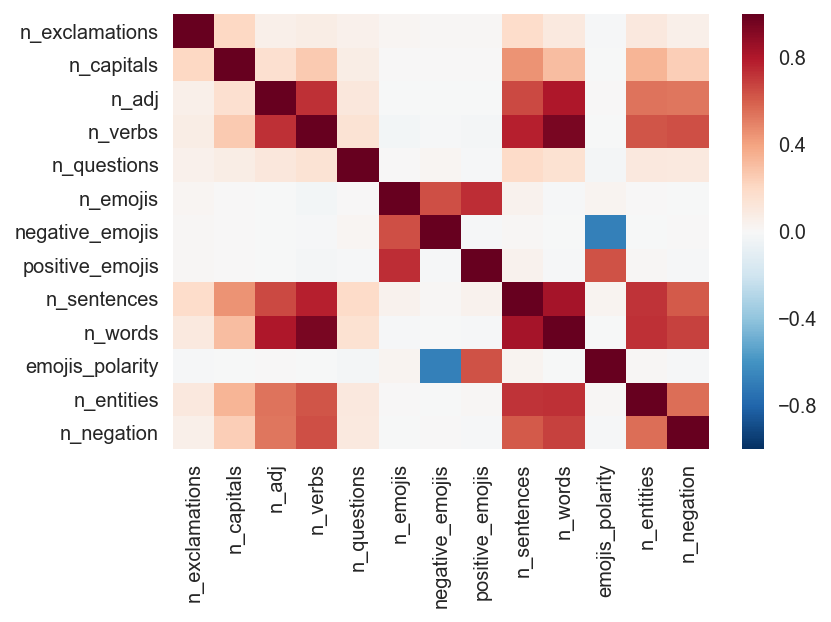

In [70]:
sns.heatmap(numerical_features.corr());

/Users/iairlinker/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,n_words,0.053155,1.000000,1,12,1,0.013980,7
1,n_adj,0.030365,0.571242,2,3,2,0.106804,1
3,n_verbs,0.021677,0.407807,3,11,3,0.030059,5
8,n_exclamations,0.004554,0.085678,5,9,4,0.034829,3
2,n_sentences,0.029249,0.550260,4,8,5,0.033083,4
4,n_negation,0.010833,0.203790,7,4,6,0.058202,2
10,n_questions,0.000000,0.000000,9,7,7,0.013336,8
6,n_capitals,0.004957,0.093247,6,13,8,0.008189,9
9,n_entities,0.002036,0.038296,8,10,9,0.017959,6
7,emojis_polarity,0.004562,0.085829,10,6,10,0.000000,13


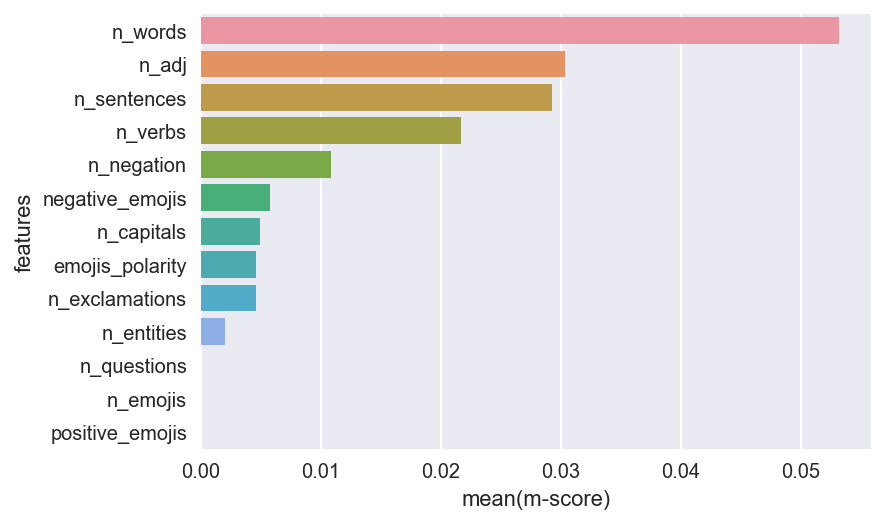

In [71]:
y=df.case
X_features_count=df[features]
selected_features=variable_selection(X_features_count,y)
sns.barplot(x='m-score', y='features', data=selected_features);
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

/Users/iairlinker/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,n_words,0.053098,1.000000,1,2,1,0.000000,11
1,n_adj,0.030176,0.568308,2,1,2,0.000000,4
3,n_verbs,0.021588,0.406561,3,3,3,0.000000,5
8,n_exclamations,0.004541,0.085522,5,6,4,0.000000,2
2,n_sentences,0.028994,0.546042,4,5,5,0.000000,10
4,n_negation,0.010754,0.202537,7,4,6,0.000000,13
10,n_questions,0.000000,0.000000,9,8,7,0.000000,6
7,n_capitals,0.004904,0.092364,6,7,8,0.000000,3
9,n_entities,0.001937,0.036483,8,10,9,0.000000,12
5,emojis_polarity,0.005838,0.109953,10,11,10,0.038677,1


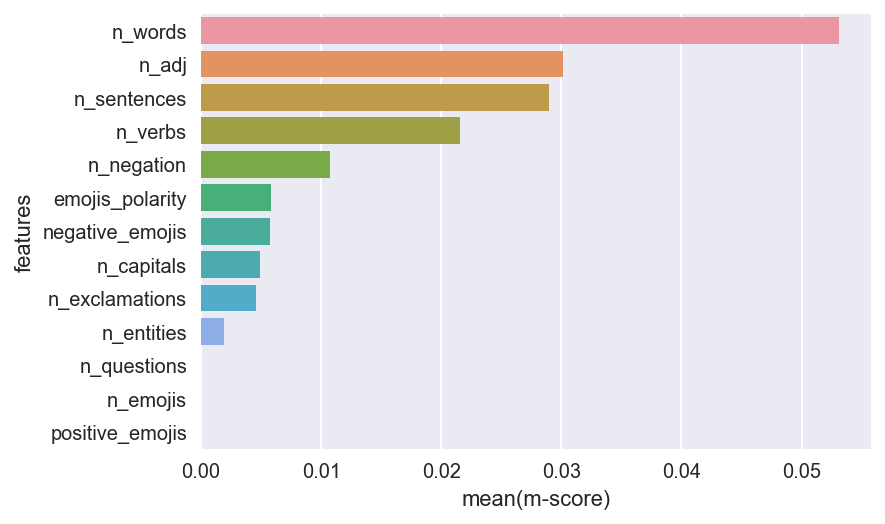

In [72]:
y=df.case
X_features_norm=numerical_features
selected_features=variable_selection(X_features_norm,y)
sns.barplot(x='m-score', y='features', data=selected_features);
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

### Conclusions of the feature selection for the numeric values

* Base in the analysis of all the graphics and test that we have made, the mutual information score's and results of the RFE selection with GB:
    
    * We leave out all the emojis features except for one, the negative emojis , because they constantly appear 
    between the least significance variables. We use negative emojis instead of the emojis polarity because this 
    features (😡) appears as the most important feature when we use the "emotion weight" as the metric to mesure the 
    significance of them, with a 0.25
    
    * We keep n_sentences because it's appear in the top 6 (all data) or 5 (balanced data) for GB rankings

** emotion weight is calculate as the sum of positive weight and negative weight**
** positive weight is the relative (because the denominator is the maximum number of appearances) percentage of times that the word_pos appear in a positive sentence**
** negative weight is the relative (because the denominator is the maximum number of appearances) percentage of times that the word_pos appear in a negative sentence**

In [73]:
selected_features=['n_words','n_adj','n_sentences','n_verbs','n_negation','emojis_polarity','n_capitals',
                   'n_exclamations','n_entities']

### Create the vectors to train the model

Información del dataset:
 las clases del target son: Counter({1: 4575, 0: 4089, 2: 3963})


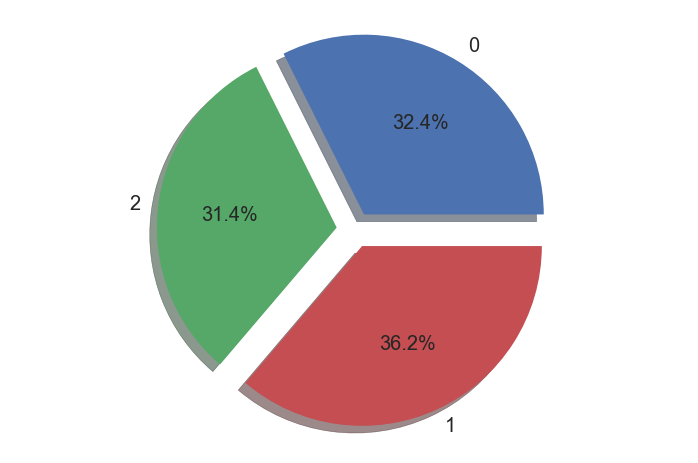

In [74]:
# Create a series to store the labels: y
y = df.case
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

Información del dataset:
 las clases del target son: Counter({1: 3447, 0: 3023, 2: 3000})


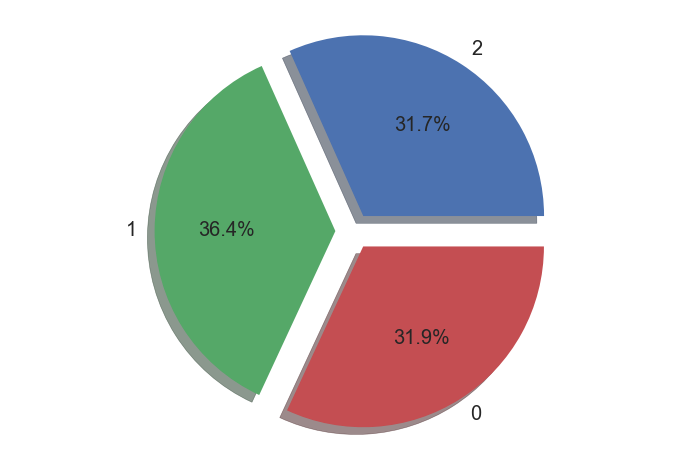

In [75]:
# Print the head of df
X=df.iloc[:,range(1,df.shape[1])]
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.25)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [76]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [77]:
# the vectorizer and classifer to use
# note that I changed the tokenizer in CountVectorizer to use a custom function using spaCy's tokenizer

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),stop_words='english',lowercase=True,token_pattern="[^A-Za-z0-9]*",
    strip_accents = 'unicode',min_df=10,ngram_range=(1,2))

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.clean_message)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test.clean_message)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer_spacy = CountVectorizer(
    tokenizer=spacy_tokenizer,stop_words='english',lowercase=True,strip_accents = 'unicode',
    min_df=10,ngram_range=(1,2))

# Transform the training data using only the 'text' column values: count_train 
count_train_spacy = count_vectorizer_spacy.fit_transform(X_train.clean_message)

# Transform the test data using only the 'text' column values: count_test 
count_test_spacy = count_vectorizer_spacy.transform(X_test.clean_message)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),stop_words='english',lowercase=True,token_pattern="[^A-Za-z0-9]*",
    strip_accents = 'unicode',min_df=10,ngram_range=(1,2))

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.clean_message)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.clean_message)

/Users/iairlinker/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



#### Add the numerical features to the array

*<https://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-an-numpy-array>*

*<http://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost>*

In [78]:
def add_features(vectorizer,X,vector_train,selected_features):
    n=len(selected_features)
    i=len(vector_train.toarray())
    j=len(vector_train.toarray()[0])
    a=vector_train.toarray()
    b = np.zeros((i,j+n))
    b[:,:-n] = a
    features_values=[X.loc[:,feature] for feature in selected_features]
    for i in range(n):
        b[:,j+i]=features_values[i]
    column_names=vectorizer.get_feature_names()
    [column_names.append(selected_features[i]) for i in range(n)]
    
    return [b,column_names]

In [79]:
def add_column_names(vectorizer,selected_features):
    n=len(selected_features)
    column_names=vectorizer.get_feature_names()
    [column_names.append(selected_features[i]) for i in range(n)]
    return column_names

In [80]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Calculate the difference in columns: difference
difference = set(tfidf_df.columns) - set(count_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

set()
False


In [81]:
count_features_train,col_names_count_features_train=add_features(
    vectorizer=count_vectorizer,X=X_train,vector_train=count_train,selected_features=selected_features)

count_features_test,col_names_count_features_test=add_features(
    vectorizer=count_vectorizer,X=X_test,vector_train=count_test,selected_features=selected_features)

In [82]:
count_features_spacy_train,col_names_count_spacy_features_train=add_features(
    vectorizer=count_vectorizer_spacy,X=X_train,vector_train=count_train_spacy,selected_features=selected_features)

count_features_spacy_test,col_names_count_spacy_features_test=add_features(
    vectorizer=count_vectorizer_spacy,X=X_test,vector_train=count_test_spacy,selected_features=selected_features)

In [83]:
tfidf_features_train,col_names_tfidf_features_train=add_features(
    vectorizer=tfidf_vectorizer,X=numerical_features.loc[X_train.index,selected_features],vector_train=tfidf_train,selected_features=selected_features)

tfidf_features_test,col_names_tfidf_features_test=add_features(
    vectorizer=tfidf_vectorizer,X=numerical_features.loc[X_test.index,selected_features],vector_train=tfidf_test,selected_features=selected_features)

In [84]:
# Create the CountVectorizer DataFrame: count_df
count_features_train_df = pd.DataFrame(count_features_train, columns=col_names_count_features_train)

# Create the CountVectorizerSpacy DataFrame: count_df
count_features_spacy_train_df = pd.DataFrame(count_features_spacy_train, columns=col_names_count_spacy_features_train)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_features_train_df = pd.DataFrame(tfidf_features_train, columns=col_names_tfidf_features_train)

# Calculate the difference in columns: difference
difference = set(tfidf_features_train_df.columns) - set(count_features_train_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

set()
False


### Create all the trainning datasets which we are going to use

Información del dataset:
 las clases del target son: Counter({0: 3000, 1: 3000, 2: 3000})


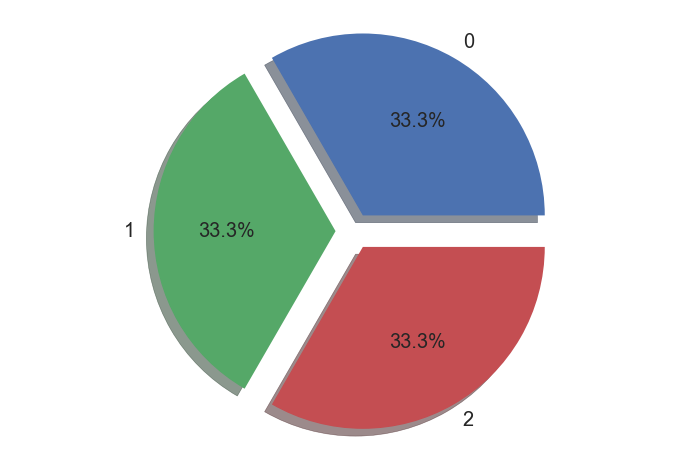

In [85]:
count_train_us, y_train_count_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(count_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_count_us)))
plot_pie(y_train_count_us)

Información del dataset:
 las clases del target son: Counter({0: 3000, 1: 3000, 2: 3000})


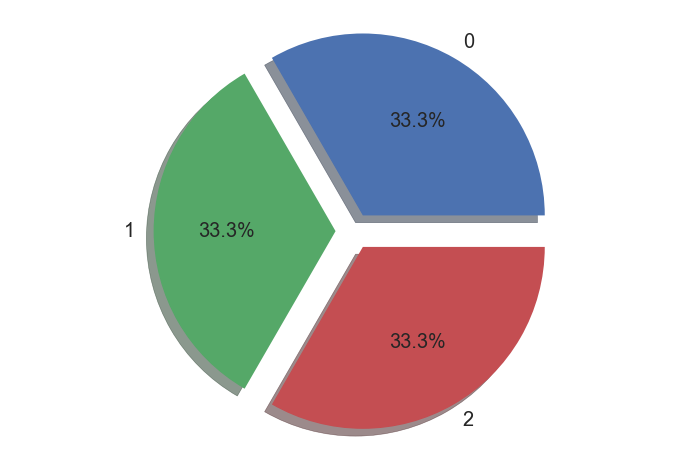

In [86]:
tfidf_train_us, y_train_tfidf_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(tfidf_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_tfidf_us)))
plot_pie(y_train_tfidf_us)

Información del dataset:
 las clases del target son: Counter({0: 3000, 1: 3000, 2: 3000})


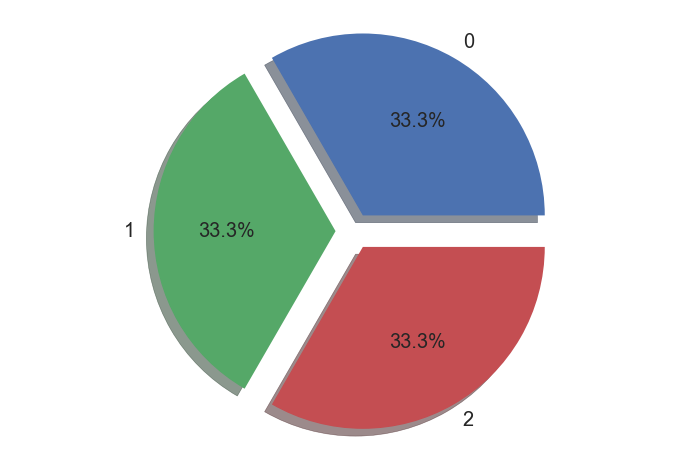

In [87]:
count_features_train_us, y_train_count_feature_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(count_features_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_count_feature_us)))
plot_pie(y_train_count_feature_us)

Información del dataset:
 las clases del target son: Counter({0: 3000, 1: 3000, 2: 3000})


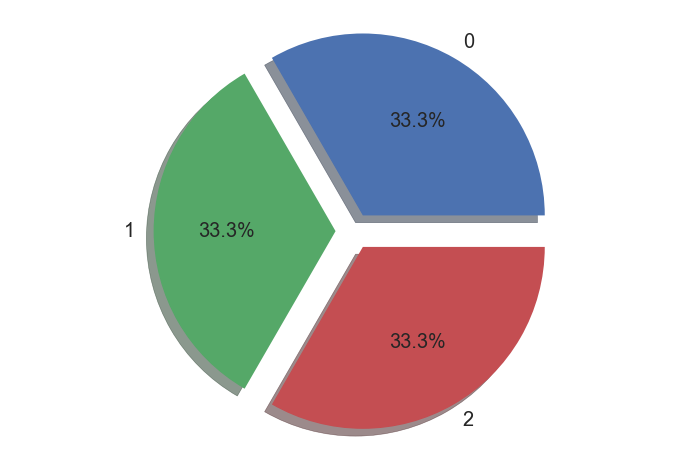

In [88]:
tfidf_features_train_us, y_train_tfidf_feature_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(tfidf_features_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_tfidf_feature_us)))
plot_pie(y_train_tfidf_feature_us)

## Training

**References:** 

* Functions to model: *<http://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost>*
* Got a lot of code and ideas from here: *<https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy>*
* The idea to include de Pasive Aggresive Classifier was from here: *<https://www.datacamp.com/community/tutorials/scikit-learn-fake-news>*

In [108]:
scores={'accuracy': make_scorer(accuracy_score)}

In [90]:
def train_classifier(X_train, y_train, X_test, models,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train,
                                    cv = 10,return_train_score=False)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [ ]:
def restart_multinomial_classifiers():
    classifier_LR =LogisticRegression(multi_class='multinomial', solver='newton-cg',random_state=0,
                                      warm_start=True,C=0.01,max_iter=300)
    classifier_RF = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=True,n_jobs=-1, min_samples_leaf =50)
    classifier_BNB=BernoulliNB()
    classifier_linearSVC=LinearSVC(penalty='l2',C=0.01,multi_class="crammer_singer")
    algorithms=[classifier_LR,classifier_BNB,classifier_RF,classifier_linearSVC]
    
    classifier_LR_wc = LogisticRegression(random_state=0,class_weight='balanced',multi_class='multinomial', 
                                          solver='newton-cg',warm_start=False,C=0.01,max_iter=300)
    classifier_RF_wc = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=False,n_jobs=-1, min_samples_leaf =50,class_weight='balanced')
    algorithms_wc=[classifier_LR_wc,classifier_BNB,classifier_linearSVC,classifier_RF_wc]

    return [algorithms,algorithms_wc]

In [91]:
scores={'accuracy': make_scorer(accuracy_score)}
algorithms,algorithms_wc=restart_multinomial_classifiers()
results_count, predictions_count=train_classifier(
    X_train=count_train,y_train=y_train,X_test=count_test,models=algorithms_wc)
results_count.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
2,LinearSVC,NaN,0.700952,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': True...",2.45145
0,LogisticRegression,NaN,0.629775,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.506085
1,BernoulliNB,NaN,0.61119,NaN,NaN,NaN,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.00700471
3,RandomForestClassifier,NaN,0.571377,NaN,NaN,NaN,"{'bootstrap': True, 'class_weight': 'balanced'...",0.912652


In [92]:
scores={'accuracy': make_scorer(accuracy_score)}
algorithms,algorithms_wc=restart_multinomial_classifiers()
results_count_spacy, predictions_count_spacy=train_classifier(
    X_train=count_train_spacy,y_train=y_train,X_test=count_test_spacy,models=algorithms_wc)
results_count_spacy.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count_spacy

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
2,LinearSVC,NaN,0.695464,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': True...",0.184116
0,LogisticRegression,NaN,0.633368,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.499222
1,BernoulliNB,NaN,0.573807,NaN,NaN,NaN,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.00776887
3,RandomForestClassifier,NaN,0.571905,NaN,NaN,NaN,"{'bootstrap': True, 'class_weight': 'balanced'...",1.02664


In [93]:
scores={'accuracy': make_scorer(accuracy_score)}
algorithms,algorithms_wc=restart_multinomial_classifiers()
results_tfidf, predictions_tfidf=train_classifier(
    X_train=tfidf_train,y_train=y_train,X_test=tfidf_test,models=algorithms_wc)
results_tfidf.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_tfidf

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
2,LinearSVC,NaN,0.641502,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': True...",0.11217
1,BernoulliNB,NaN,0.61119,NaN,NaN,NaN,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.0071342
0,LogisticRegression,NaN,0.609183,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.177173
3,RandomForestClassifier,NaN,0.579297,NaN,NaN,NaN,"{'bootstrap': True, 'class_weight': 'balanced'...",1.01842


In [94]:
scores={'accuracy': make_scorer(accuracy_score)}
algorithms,algorithms_wc=restart_multinomial_classifiers()
results_count_us, predictions_count_us=train_classifier(
    X_train=count_train_us,y_train=y_train_count_us,X_test=count_test,models=algorithms)
results_count_us.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count_us

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
3,LinearSVC,NaN,0.703667,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': True...",1.54116
0,LogisticRegression,NaN,0.628222,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': Fals...",0.409739
1,BernoulliNB,NaN,0.609778,NaN,NaN,NaN,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.00462301
2,RandomForestClassifier,NaN,0.560667,NaN,NaN,NaN,"{'bootstrap': True, 'class_weight': None, 'cri...",0.840002


In [95]:
scores={'accuracy': make_scorer(accuracy_score)}
algorithms,algorithms_wc=restart_multinomial_classifiers()
results_tfidf_us, predictions_tfidf_us=train_classifier(
    X_train=tfidf_train_us,y_train=y_train_tfidf_us,X_test=tfidf_test,models=algorithms)
results_tfidf_us.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_tfidf_us

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
3,LinearSVC,NaN,0.651444,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': True...",0.147441
0,LogisticRegression,NaN,0.609778,NaN,NaN,NaN,"{'C': 0.01, 'class_weight': None, 'dual': Fals...",0.15859
1,BernoulliNB,NaN,0.609778,NaN,NaN,NaN,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.00453358
2,RandomForestClassifier,NaN,0.574556,NaN,NaN,NaN,"{'bootstrap': True, 'class_weight': None, 'cri...",1.01423


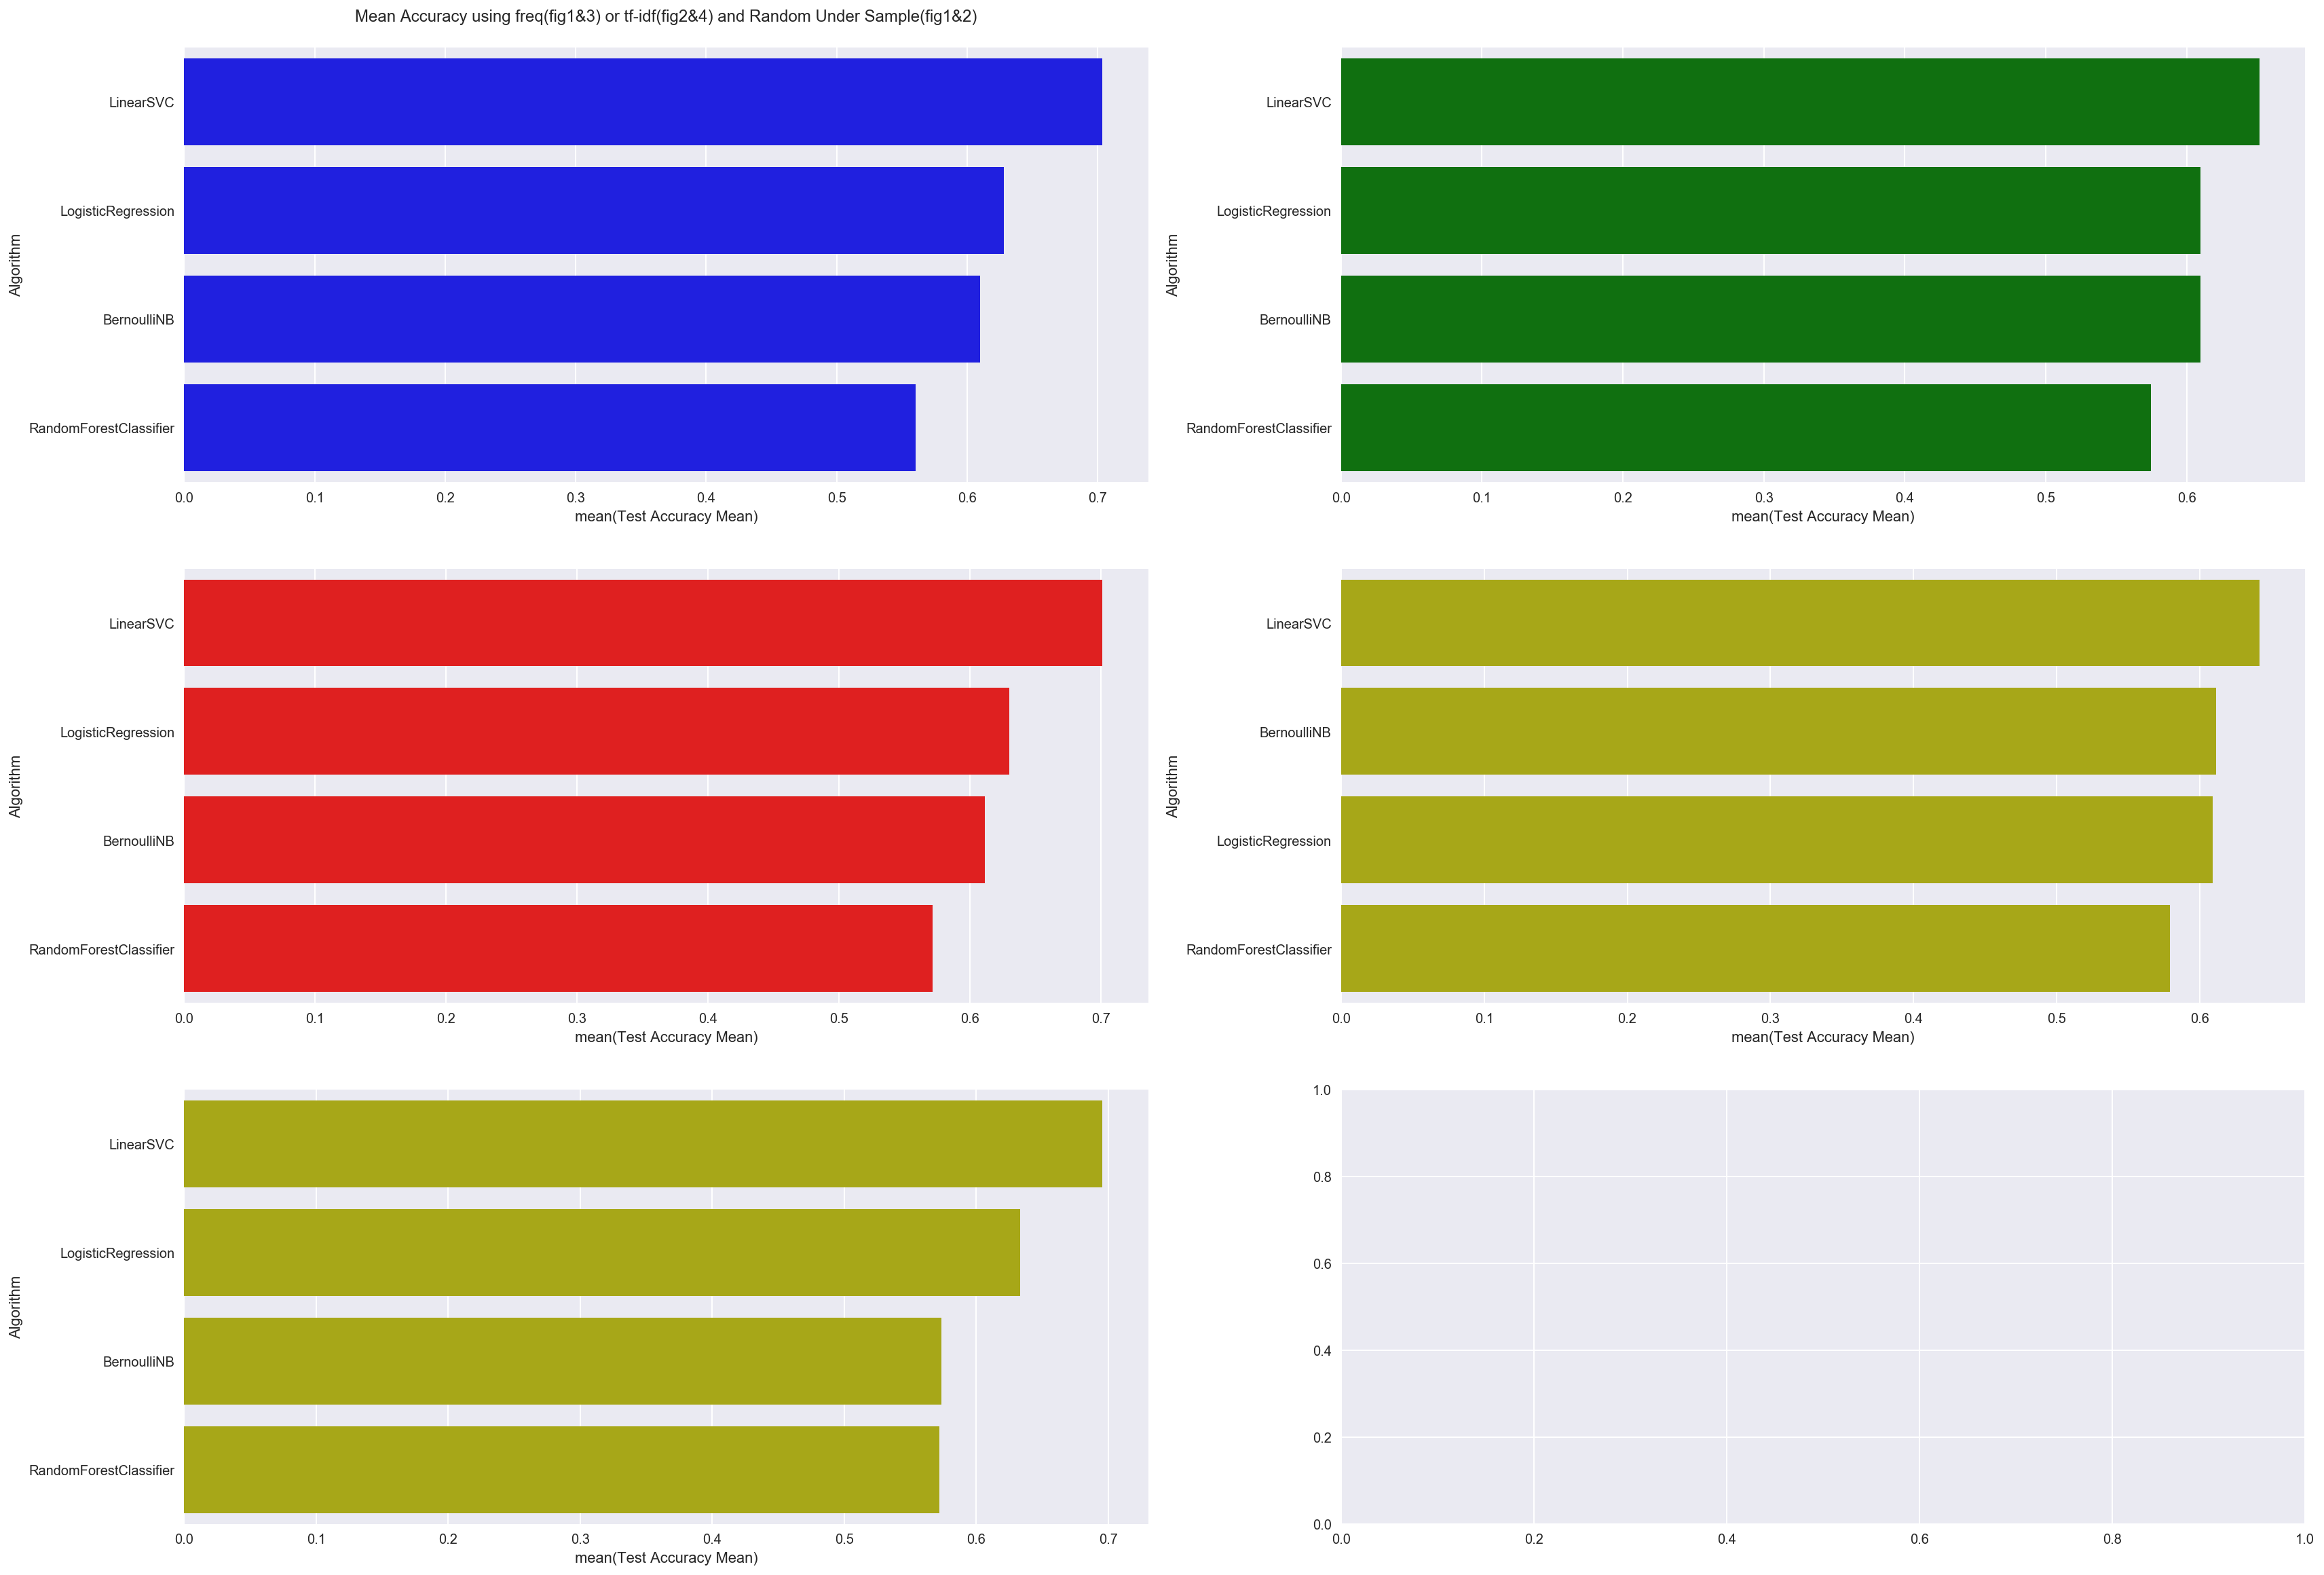

In [160]:
#more side-by-side comparisons
fig, axis = plt.subplots(3, 2,figsize=(28,20))

axis[0,0].set_title('Mean Accuracy using freq(fig1&3) or tf-idf(fig2&4) and Random Under Sample(fig1&2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_count_us, color = 'b',ax = axis[0,0])
#sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count_us, color = 'b',ax = axis[0,1])
#axis[0,1].set_title('Recall using freq(fig1&3) or tf-idf(fig2&4) and Random Under Sample(fig1&2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_tfidf_us, color = 'g',ax = axis[0,1])
#sns.barplot(x='Test Recall', y = 'Algorithm', data = results_tfidf_us, color = 'g',ax = axis[1,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_count, color = 'r',ax = axis[1,0])
#sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count, color = 'r',ax = axis[2,1])
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_tfidf, color = 'y',ax = axis[1,1])
#sns.barplot(x='Test Recall', y = 'Algorithm', data = results_tfidf, color = 'y',ax = axis[3,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data =results_count_spacy , color = 'y',ax = axis[2,0]);
#sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count_spacy, color = 'y',ax = axis[4,1]);